<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Credit_Default_Fine_Tuning_Extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Default: Predicting Loan Default using Fine-tuning on Payment Lateness

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C55S3H):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [4]:
X

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...     X14    X15    X16  \
0       20000   2   2   1  24   2   2  -1  -1   -2  ...     689      0      0   
1      120000   2   2   2  26  -1   2   0   0    0  ...    2682   3272   3455   
2       90000   2   2   2  34   0   0   0   0    0  ...   13559  14331  14948   
3       50000   2   2   1  37   0   0   0   0    0  ...   49291  28314  28959   
4       50000   1   2   1  57  -1   0  -1   0    0  ...   35835  20940  19146   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...     ...    ...    ...   
29995  220000   1   3   1  39   0   0   0   0    0  ...  208365  88004  31237   
29996  150000   1   3   2  43  -1  -1  -1  -1    0  ...    3502   8979   5190   
29997   30000   1   2   2  37   4   3   2  -1    0  ...    2758  20878  20582   
29998   80000   1   3   1  41   1  -1   0   0    0  ...   76304  52774  11855   
29999   50000   1   2   1  46   0   0   0   0    0  ...   49764  36535  32428   

         X17    X18    X19    X20   X21    X22   X23  
0          0      0    689      0     0      0     0  
1       3261      0   1000   1000  1000      0  2000  
2      15549   1518   1500   1000  1000   1000  5000  
3      29547   2000   2019   1200  1100   1069  1000  
4      19131   2000  36681  10000  9000    689   679  
...      ...    ...    ...    ...   ...    ...   ...  
29995  15980   8500  20000   5003  3047   5000  1000  
29996      0   1837   3526   8998   129      0     0  
29997  19357      0      0  22000  4200   2000  3100  
29998  48944  85900   3409   1178  1926  52964  1804  
29999  15313   2078   1800   1430  1000   1000  1000  

[30000 rows x 23 columns]

In [5]:
X.iloc[:,2].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [6]:
data_all = pd.concat([X,y],axis=1)

## Cleaning up education:
data_all = data_all[(data_all.iloc[:,2] !=6) & (data_all.iloc[:,2] !=5) & (data_all.iloc[:,2] !=0)].reset_index(drop=True)

## Cleaning up September 2005 Pay_0 to only take values listed in repo:
data_all = data_all[(data_all.iloc[:,5] !=-2)].reset_index(drop=True)

## Creating binary outcome of whether September 2005 payment is late:
y2 = []
for i in range(len(data_all)):
  if data_all.iloc[i, 5] > 0:
    y2.append(1)
  else:
    y2.append(0)

data_all['Y2'] = y2

## Dropping the September 2005 lateness factor X6 for analyzing the Y2 variable:
data_all = data_all.drop(columns = ['X6'])

data_all

X1  X2  X3  X4  X5  X7  X8  X9  X10  X11  ...    X16    X17    X18  \
0       20000   2   2   1  24   2  -1  -1   -2   -2  ...      0      0      0   
1      120000   2   2   2  26   2   0   0    0    2  ...   3455   3261      0   
2       90000   2   2   2  34   0   0   0    0    0  ...  14948  15549   1518   
3       50000   2   2   1  37   0   0   0    0    0  ...  28959  29547   2000   
4       50000   1   2   1  57   0  -1   0    0    0  ...  19146  19131   2000   
...       ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...    ...    ...    ...   
26935  220000   1   3   1  39   0   0   0    0    0  ...  31237  15980   8500   
26936  150000   1   3   2  43  -1  -1  -1    0    0  ...   5190      0   1837   
26937   30000   1   2   2  37   3   2  -1    0    0  ...  20582  19357      0   
26938   80000   1   3   1  41  -1   0   0    0   -1  ...  11855  48944  85900   
26939   50000   1   2   1  46   0   0   0    0    0  ...  32428  15313   2078   

         X19    X20   X21    X22   X23  Y  Y2  
0        689      0     0      0     0  1   1  
1       1000   1000  1000      0  2000  1   0  
2       1500   1000  1000   1000  5000  0   0  
3       2019   1200  1100   1069  1000  0   0  
4      36681  10000  9000    689   679  0   0  
...      ...    ...   ...    ...   ... ..  ..  
26935  20000   5003  3047   5000  1000  0   0  
26936   3526   8998   129      0     0  0   0  
26937      0  22000  4200   2000  3100  1   1  
26938   3409   1178  1926  52964  1804  1   1  
26939   1800   1430  1000   1000  1000  1   0  

[26940 rows x 24 columns]

In [7]:
X = data_all.iloc[:, :-2]
y = data_all.iloc[:,-2]
y2 = data_all.iloc[:,-1]
y

0        1
1        1
2        0
3        0
4        0
        ..
26935    0
26936    0
26937    1
26938    1
26939    1
Name: Y, Length: 26940, dtype: int64

In [15]:
X.iloc[:,2].value_counts()

X3
2    13054
1     9217
3     4575
4       94
Name: count, dtype: int64

In [9]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [10]:
data2 = pd.concat([X_scaled, y, y2], axis=1)
data2

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
26935  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
26936  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
26937  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
26938  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   
26939  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
0      ...  0.080648  0.260979  0.000000  0.000561  0.000000  0.000000   
1      ...  0.084074  0.263485  0.000000  0.000815  0.001116  0.001610   
2      ...  0.095470  0.272928  0.001738  0.001222  0.001116  0.001610   
3      ...  0.109363  0.283685  0.002290  0.001645  0.001339  0.001771   
4      ...  0.099633  0.275681  0.002290  0.029893  0.011160  0.014493   
...    ...       ...       ...       ...       ...       ...       ...   
26935  ...  0.111622  0.273259  0.009730  0.016299  0.005583  0.004907   
26936  ...  0.085794  0.260979  0.002103  0.002873  0.010042  0.000208   
26937  ...  0.101057  0.275854  0.000000  0.000000  0.024552  0.006763   
26938  ...  0.092403  0.298591  0.098334  0.002778  0.001315  0.003101   
26939  ...  0.112803  0.272746  0.002379  0.001467  0.001596  0.001610   

             20        21  Y  Y2  
0      0.000000  0.000000  1   1  
1      0.000000  0.003783  1   0  
2      0.002345  0.009458  0   0  
3      0.002506  0.001892  0   0  
4      0.001615  0.001284  0   0  
...         ...       ... ..  ..  
26935  0.011723  0.001892  0   0  
26936  0.000000  0.000000  0   0  
26937  0.004689  0.005864  1   1  
26938  0.124174  0.003412  1   1  
26939  0.002345  0.001892  1   0  

[26940 rows x 24 columns]

In [11]:
y.value_counts()

Y
0    20694
1     6246
Name: count, dtype: int64

In [12]:
y2.value_counts()

Y2
0    20167
1     6773
Name: count, dtype: int64

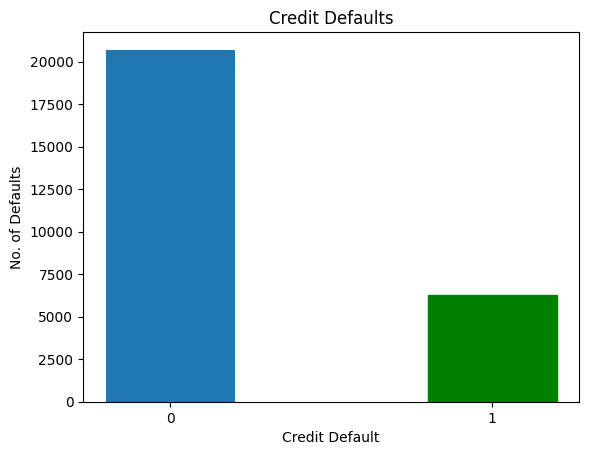

In [13]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Credit Default")
plt.ylabel("No. of Defaults")
plt.title("Credit Defaults")
plt.show()

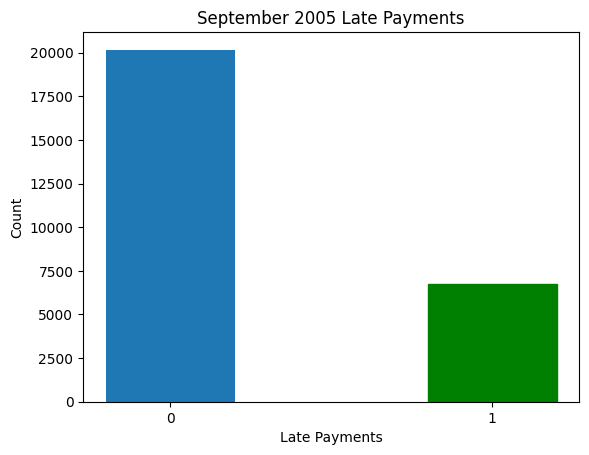

In [14]:
barlist = plt.bar([str(0),str(1)], y2.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Late Payments")
plt.ylabel("Count")
plt.title("September 2005 Late Payments")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:


In [16]:
data_S = data2[data2[2] <= 0.5].reset_index(drop=True)  ## Source domain and classification
data_S_X = data_S.iloc[:,:-2]
data_S_y = data_S.iloc[:, -1]    ## Response variable of interest is Sept 2005 Late Payment

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2[data2[2] > 0.5].reset_index(drop=True) ## Target domain and classification

data_T_X = data_T.iloc[:,:-2]
data_T_y = data_T.iloc[:, -2]    ## Response variable of interest in Default

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [17]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [18]:
data_T_full

0    1         2         3         4    5    6    7    8    9  \
0     0.131313  1.0  0.666667  0.333333  0.120690  0.2  0.4  0.2  0.2  0.2   
1     0.191919  1.0  0.666667  0.666667  0.224138  0.2  0.4  0.2  0.2  0.1   
2     0.040404  1.0  0.666667  1.000000  0.034483  0.4  0.2  0.2  0.2  0.2   
3     0.121212  1.0  0.666667  0.666667  0.310345  0.2  0.2  0.2  0.2  0.1   
4     0.040404  0.0  0.666667  0.666667  0.034483  0.2  0.2  0.2  0.2  0.2   
...        ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
4664  0.040404  0.0  0.666667  0.666667  0.362069  0.2  0.2  0.2  0.2  0.2   
4665  0.000000  0.0  0.666667  0.333333  0.379310  0.2  0.2  0.0  0.0  0.0   
4666  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
4667  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
4668  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   

      ...        13        14        15        16        17        18  \
0     ...  0.171640  0.092342  0.263837  0.003811  0.000000  0.000482   
1     ...  0.162505  0.082461  0.263846  0.002640  0.000010  0.000056   
2     ...  0.187240  0.109930  0.284195  0.000000  0.001222  0.001228   
3     ...  0.179558  0.092351  0.261693  0.003434  0.001253  0.001116   
4     ...  0.187424  0.110226  0.284069  0.002259  0.001162  0.001117   
...   ...       ...       ...       ...       ...       ...       ...   
4664  ...  0.207576  0.100451  0.276113  0.011448  0.003260  0.005580   
4665  ...  0.160138  0.080648  0.260979  0.002290  0.000000  0.000000   
4666  ...  0.243036  0.111622  0.273259  0.009730  0.016299  0.005583   
4667  ...  0.168596  0.085794  0.260979  0.002103  0.002873  0.010042   
4668  ...  0.209850  0.092403  0.298591  0.098334  0.002778  0.001315   

            19        20        21  Y  
0     0.001610  0.002345  0.001892  0  
1     0.000483  0.008764  0.000125  0  
2     0.001932  0.003048  0.002081  0  
3     0.003221  0.002180  0.063866  0  
4     0.002306  0.002490  0.001886  0  
...        ...       ...       ... ..  
4664  0.004831  0.010550  0.003783  0  
4665  0.000000  0.000000  0.000000  0  
4666  0.004907  0.011723  0.001892  0  
4667  0.000208  0.000000  0.000000  0  
4668  0.003101  0.124174  0.003412  1  

[4669 rows x 23 columns]

## Source domain and task labels:

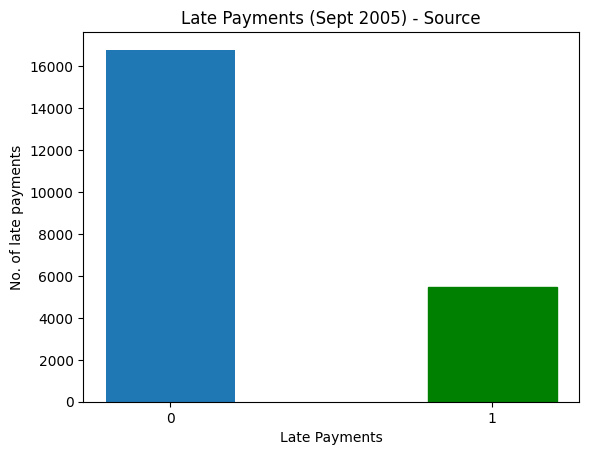

In [19]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Late Payments")
plt.ylabel("No. of late payments")
plt.title("Late Payments (Sept 2005) - Source")
plt.show()

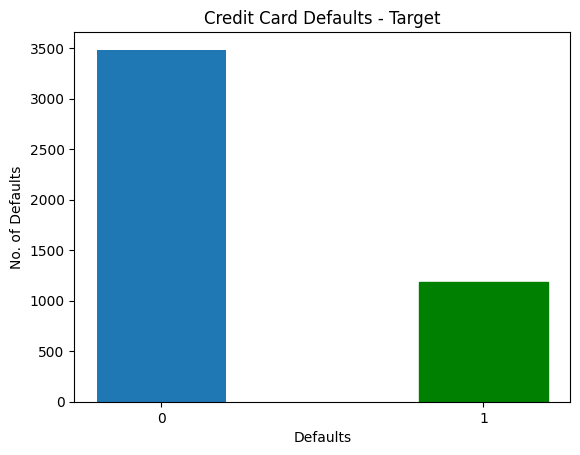

In [20]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Credit Card Defaults - Target")
plt.show()

## Updated Code (Modified from Shreya's code):

In [21]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model

# def create_dnn_model(input_shape):
#   model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
#     ])

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

#   return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [22]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])

    print(fpr)
    print(fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return fpr, fnr


In [23]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False
    for layer in new_model.layers[-1:]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    fpr, fnr = train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")
    return fpr, fnr

In [24]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [25]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy

## Oversampling functions:

In [26]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :-1]
    y_SRS = data_SRS_ROS.iloc[:, -1]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :-1]
    y_Sy = data_Sy_ROS.iloc[:, -1]

    return X_Sy, y_Sy

# k = 48

# Nsamples = k*(oversample_size-undersample_size)/undersample_size
# # print(Nsamples)

# np.random.seed(123)
# start = np.random.choice(int(k), int(Nsamples), replace=True)
# # print(start)


# Row = []

# for j in range(len(start)):
#   for i in range(int(undersample_size/k)):
#     row = start[j]+int(k*i)-1
#     Row.append(row)

In [27]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

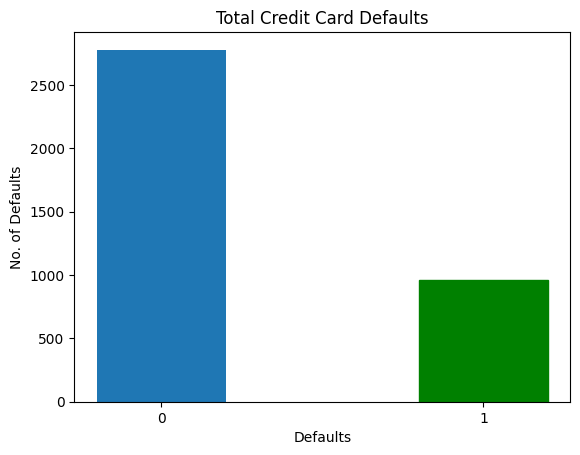

In [28]:
barlist = plt.bar([str(0),str(1)], y_T_train.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Total Credit Card Defaults")
plt.show()

In [29]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (17816, 22)
y_S_train: (17816,)
X_S_test: (4455, 22)
y_S_test: (4455,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.5192 - loss: 0.6014 - val_AUC: 0.6698 - val_loss: 0.5365
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6719 - loss: 0.5392 - val_AUC: 0.7022 - val_loss: 0.5103
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6935 - loss: 0.5097 - val_AUC: 0.7062 - val_loss: 0.4997
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6957 - loss: 0.5195 - val_AUC: 0.6934 - val_loss: 0.5063
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6924 - loss: 0.5118 - val_AUC: 0.7100 - val_loss: 0.5065
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 - loss: 0.5123 - val_AUC: 0.7079 - val_loss: 0.4961
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7064 - loss: 0.5067 - val_AUC: 0.7116 - val_loss: 0.4950
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7091 - loss: 0.5090 - val_AUC: 0.7168 - val_loss: 0.4979
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7145 - los

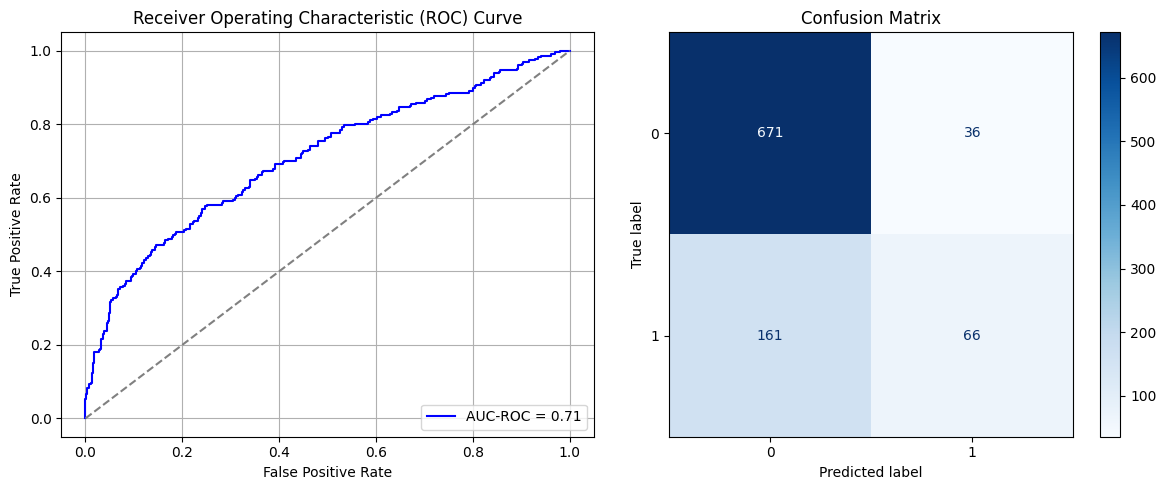

Best threshold based on F1-score: 0.22618257999420166
Time elapsed (performance): 10.740811709000013


<Sequential name=sequential, built=True>

In [30]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [31]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6881 - loss: 0.4988 - val_AUC: 0.9129 - val_loss: 0.2568
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9094 - loss: 0.2524 - val_AUC: 0.9182 - val_loss: 0.2369
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9184 - loss: 0.2399 - val_AUC: 0.9202 - val_loss: 0.2372
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9138 - loss: 0.2463 - val_AUC: 0.9190 - val_loss: 0.2343
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9239 - loss: 0.2310 - val_AUC: 0.9257 - val_loss: 0.2290
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9173 - loss: 0.2361 - val_AUC: 0.9139 - val_loss: 0.2531
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9237 - loss: 0.2289 - val_AUC: 0.9179 - val_loss: 0.2430
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9263 - loss: 0.2277 - val_AUC: 0.9147 - val_loss: 0.2320
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AU

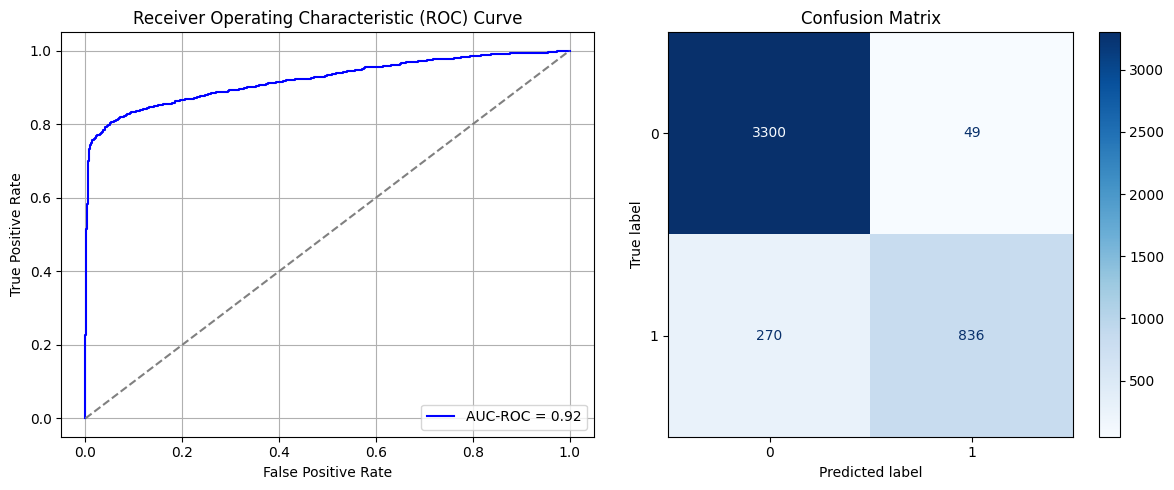

Best threshold based on F1-score: 0.50375896692276
Time elapsed (performance): 23.546203140999978


<Sequential name=sequential_1, built=True>

In [32]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6912934842886428
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       707
           1       0.49      0.44      0.47       227

    accuracy                           0.75       934
   macro avg       0.66      0.65      0.65       934
weighted avg       0.75      0.75      0.75       934

FPR 0.1471004243281471 TPR: 0.44493392070484583 FNR: 0.5550660792951542 TNR: 0.8528995756718529


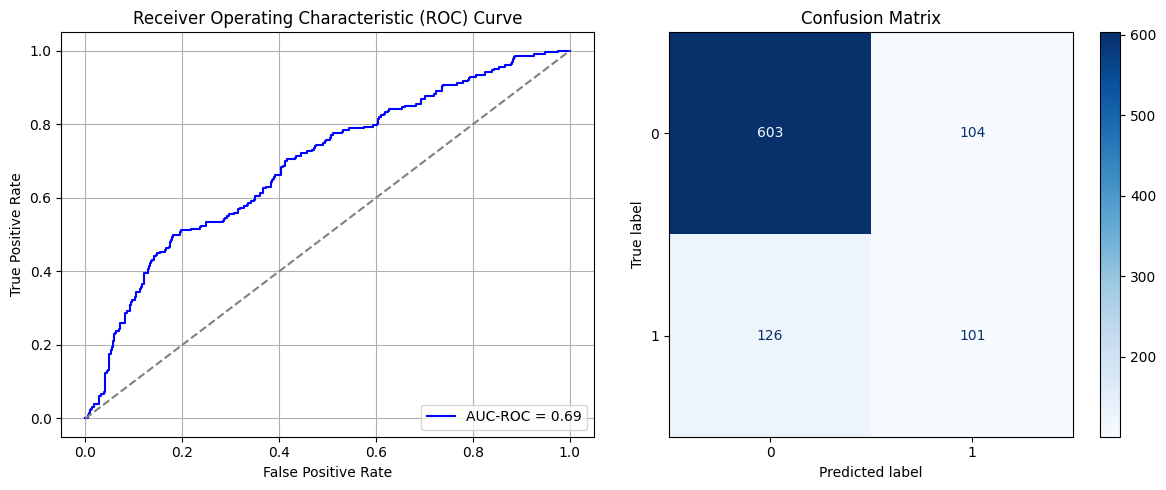

Best threshold based on F1-score: 0.999987006187439
False Negative Rate: 0.5550660792951542
Time elapsed (performance): 0.4597459899999876


<ipython-input-24-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [33]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

In [34]:
times = 10

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.6880 - loss: 0.8014 - val_AUC: 0.7146 - val_loss: 0.5303
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7300 - loss: 0.5374 - val_AUC: 0.7233 - val_loss: 0.4926
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7271 - loss: 0.5002 - val_AUC: 0.7291 - val_loss: 0.4929
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7051 - loss: 0.5406 - val_AUC: 0.7296 - val_loss: 0.4914
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7286 - loss: 0.5030 - val_AUC: 0.7329 - val_loss: 0.4873
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7301 - loss: 0.5004 - val_AUC: 0.7353 - val_loss: 0.4873
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5041 - val_AUC: 0.7359 - val_loss: 0.4871
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7253 - loss: 0.4905 - val_AUC: 0.738

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6856 - loss: 0.8475 - val_AUC: 0.7157 - val_loss: 0.5302
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6961 - loss: 0.5553 - val_AUC: 0.7247 - val_loss: 0.4923
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7091 - loss: 0.5056 - val_AUC: 0.7280 - val_loss: 0.4895
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7157 - loss: 0.5007 - val_AUC: 0.7301 - val_loss: 0.4878
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7055 - loss: 0.5051 - val_AUC: 0.7338 - val_loss: 0.4885
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7197 - loss: 0.5062 - val_AUC: 0.7351 - val_loss: 0.4875
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7224 - loss: 0.5010 - val_AUC: 0.7365 - val_loss: 0.4865
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7286 - loss: 0.5007 - val_AUC: 0.7368 - val_loss: 0.4865
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7211 - loss: 0.5015 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6928 - loss: 0.8044 - val_AUC: 0.7158 - val_loss: 0.5315
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7024 - loss: 0.5402 - val_AUC: 0.7248 - val_loss: 0.4921
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.4979 - val_AUC: 0.7293 - val_loss: 0.4892
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7164 - loss: 0.4945 - val_AUC: 0.7309 - val_loss: 0.4885
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7580 - loss: 0.4771 - val_AUC: 0.7337 - val_loss: 0.4950
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7230 - loss: 0.4923 - val_AUC: 0.7361 - val_loss: 0.4874
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7194 - loss: 0.5072 - val_AUC: 0.7375 - val_loss: 0.4861
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7130 - loss: 0.5317 - val_AUC: 0.7375 - val_loss: 0.4874
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7389 - loss: 0.5068 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7030 - loss: 0.7994 - val_AUC: 0.7139 - val_loss: 0.5288
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6969 - loss: 0.5404 - val_AUC: 0.7234 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7254 - loss: 0.5009 - val_AUC: 0.7270 - val_loss: 0.4900
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7186 - loss: 0.5091 - val_AUC: 0.7308 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7109 - loss: 0.5256 - val_AUC: 0.7316 - val_loss: 0.4882
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7404 - loss: 0.5023 - val_AUC: 0.7343 - val_loss: 0.4883
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7213 - loss: 0.5090 - val_AUC: 0.7362 - val_loss: 0.4877
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7232 - loss: 0.5095 - val_AUC: 0.7369 - val_loss: 0.4858
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7115 - loss: 0.5174 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6859 - loss: 0.8574 - val_AUC: 0.7140 - val_loss: 0.5501
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7017 - loss: 0.5579 - val_AUC: 0.7227 - val_loss: 0.4943
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6976 - loss: 0.5040 - val_AUC: 0.7281 - val_loss: 0.4896
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7110 - loss: 0.5070 - val_AUC: 0.7294 - val_loss: 0.4897
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7123 - loss: 0.5116 - val_AUC: 0.7314 - val_loss: 0.4878
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7366 - loss: 0.4989 - val_AUC: 0.7349 - val_loss: 0.4884
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7090 - loss: 0.5107 - val_AUC: 0.7359 - val_loss: 0.4869
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5169 - val_AUC: 0.7363 - val_loss: 0.4869
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7416 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6802 - loss: 0.7840 - val_AUC: 0.7145 - val_loss: 0.5363
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7184 - loss: 0.5426 - val_AUC: 0.7235 - val_loss: 0.4930
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7064 - loss: 0.5264 - val_AUC: 0.7281 - val_loss: 0.4895
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7229 - loss: 0.4995 - val_AUC: 0.7301 - val_loss: 0.4906
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.5217 - val_AUC: 0.7310 - val_loss: 0.4882
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7247 - loss: 0.4979 - val_AUC: 0.7345 - val_loss: 0.4874
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7290 - loss: 0.5109 - val_AUC: 0.7350 - val_loss: 0.4869
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7394 - loss: 0.4866 - val_AUC: 0.7364 - val_loss: 0.4872
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7235 - loss: 0.4994 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7175 - loss: 0.7230 - val_AUC: 0.7117 - val_loss: 0.5345
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7102 - loss: 0.5291 - val_AUC: 0.7237 - val_loss: 0.4929
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7235 - loss: 0.5114 - val_AUC: 0.7277 - val_loss: 0.4904
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7233 - loss: 0.5063 - val_AUC: 0.7293 - val_loss: 0.4894
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7140 - loss: 0.5145 - val_AUC: 0.7322 - val_loss: 0.4878
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7340 - loss: 0.5000 - val_AUC: 0.7341 - val_loss: 0.4884
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7278 - loss: 0.5191 - val_AUC: 0.7357 - val_loss: 0.4875
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7323 - loss: 0.5009 - val_AUC: 0.7366 - val_loss: 0.4868
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7091 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6964 - loss: 0.7975 - val_AUC: 0.7136 - val_loss: 0.5367
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7040 - loss: 0.5347 - val_AUC: 0.7226 - val_loss: 0.4928
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7096 - loss: 0.5208 - val_AUC: 0.7277 - val_loss: 0.4909
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7171 - loss: 0.5037 - val_AUC: 0.7305 - val_loss: 0.4888
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7261 - loss: 0.5057 - val_AUC: 0.7309 - val_loss: 0.4888
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7339 - loss: 0.5013 - val_AUC: 0.7328 - val_loss: 0.4890
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6994 - loss: 0.5212 - val_AUC: 0.7355 - val_loss: 0.4863
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7083 - loss: 0.5105 - val_AUC: 0.7377 - val_loss: 0.4875
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7320 - loss: 0.4884 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7084 - loss: 0.7847 - val_AUC: 0.7113 - val_loss: 0.5421
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6993 - loss: 0.5677 - val_AUC: 0.7209 - val_loss: 0.4957
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7137 - loss: 0.5182 - val_AUC: 0.7275 - val_loss: 0.4899
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7091 - loss: 0.5062 - val_AUC: 0.7300 - val_loss: 0.4884
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7080 - loss: 0.5178 - val_AUC: 0.7324 - val_loss: 0.4881
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7307 - loss: 0.4984 - val_AUC: 0.7323 - val_loss: 0.4877
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7287 - loss: 0.4974 - val_AUC: 0.7346 - val_loss: 0.4888
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7158 - loss: 0.5126 - val_AUC: 0.7359 - val_loss: 0.4865
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7212 - loss: 0.5141 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6883 - loss: 0.8221 - val_AUC: 0.7131 - val_loss: 0.5382
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7136 - loss: 0.5447 - val_AUC: 0.7227 - val_loss: 0.4933
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7058 - loss: 0.5183 - val_AUC: 0.7279 - val_loss: 0.4905
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7264 - loss: 0.5112 - val_AUC: 0.7292 - val_loss: 0.4896
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7174 - loss: 0.5046 - val_AUC: 0.7316 - val_loss: 0.4890
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7096 - loss: 0.5190 - val_AUC: 0.7349 - val_loss: 0.4884
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7191 - loss: 0.4953 - val_AUC: 0.7361 - val_loss: 0.4902
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7158 - loss: 0.5165 - val_AUC: 0.7369 - val_loss: 0.4859
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7216 - loss: 0.4918 - va

In [36]:
print(ParamFit)
ParamFit.to_csv('Imbalanced_Fine_tuning.csv')

        FPR       FNR
0  0.072136  0.678414
1  0.082037  0.651982
2  0.083451  0.651982
3  0.046676  0.718062
4  0.093352  0.647577
5  0.072136  0.678414
6  0.093352  0.647577
7  0.074965  0.669604
8  0.087694  0.647577
9  0.080622  0.656388


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [37]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [38]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Y2'])
print(y_S_SRS)

5472
16799
8892     0
6856     0
18816    0
6588     0
11951    0
        ..
22255    1
22258    1
22266    1
22268    1
22269    1
Name: Y2, Length: 10944, dtype: int64


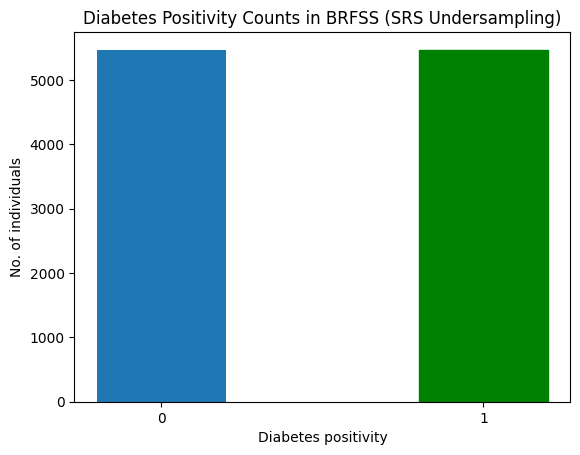

In [39]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [40]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRS)


958
2777
497     0
2803    0
1564    0
3777    0
577     0
       ..
1871    1
1701    1
2897    1
2599    1
2607    1
Name: Y, Length: 1916, dtype: int64


In [41]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [42]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7471 - loss: 0.5927 - val_AUC: 0.9012 - val_loss: 0.3682
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3722 - val_AUC: 0.9146 - val_loss: 0.3216
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9067 - loss: 0.3517 - val_AUC: 0.9132 - val_loss: 0.3207
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9083 - loss: 0.3410 - val_AUC: 0.9133 - val_loss: 0.3254
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3309 - val_AUC: 0.9214 - val_loss: 0.3075
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9224 - loss: 0.3179 - val_AUC: 0.9146 - val_loss: 0.3105
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3268 - val_AUC: 0.9256 - val_loss: 0.3153
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9185 - loss: 0.3217 - val_AUC: 0.9173 - val_loss: 0.3103
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

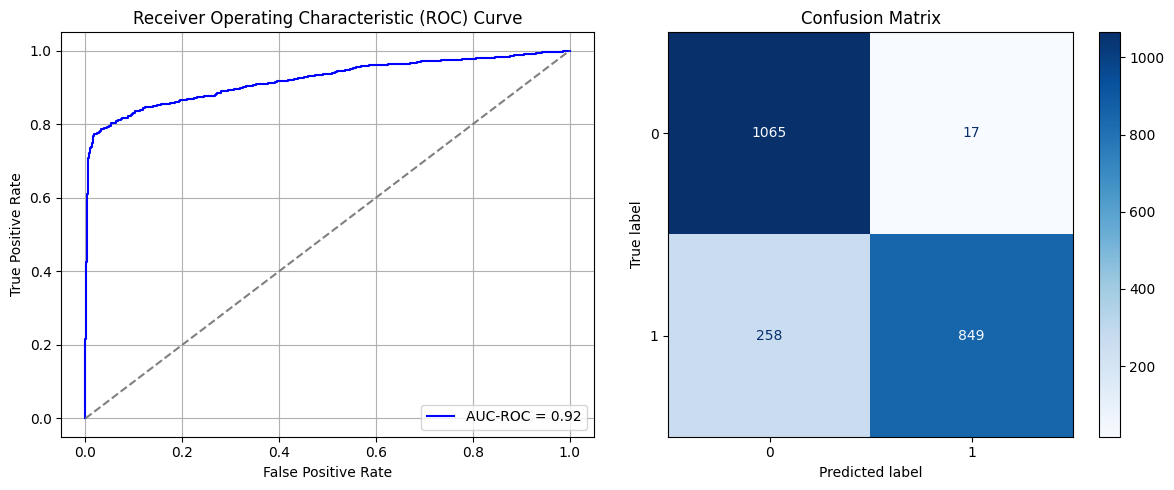

Best threshold based on F1-score: 0.29065725207328796
Time elapsed (performance): 11.969004021000046


<Sequential name=sequential_12, built=True>

In [43]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6988827894746681
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       707
           1       0.49      0.44      0.47       227

    accuracy                           0.75       934
   macro avg       0.66      0.65      0.65       934
weighted avg       0.75      0.75      0.75       934

FPR 0.1471004243281471 TPR: 0.44493392070484583 FNR: 0.5550660792951542 TNR: 0.8528995756718529


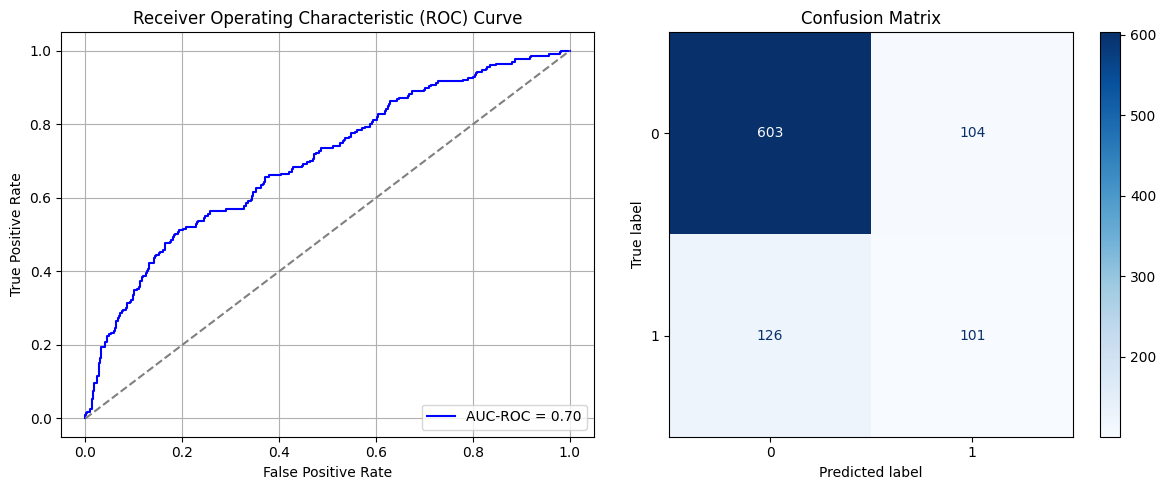

Best threshold based on F1-score: 0.2571662962436676
False Negative Rate: 0.5550660792951542
Time elapsed (performance): 0.5255945479999582


In [44]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

In [45]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7170 - loss: 0.7540 - val_AUC: 0.7161 - val_loss: 0.5260
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7143 - loss: 0.5401 - val_AUC: 0.7177 - val_loss: 0.4996
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7171 - loss: 0.5096 - val_AUC: 0.7285 - val_loss: 0.4934
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7147 - loss: 0.5195 - val_AUC: 0.7301 - val_loss: 0.4916
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7184 - loss: 0.5031 - val_AUC: 0.7307 - val_loss: 0.4900
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7334 - loss: 0.4968 - val_AUC: 0.7319 - val_loss: 0.4907
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7321 - loss: 0.5057 - val_AUC: 0.7335 - val_loss: 0.4907
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7290 - loss: 0.5071 - val_AUC: 0.7320 - val_loss: 0.4896
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7336 - loss: 0.5050 - va

(np.float64(0.09476661951909476), np.float64(0.6255506607929515))

In [46]:
times = 10

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.6989 - loss: 0.8314 - val_AUC: 0.0000e+00 - val_loss: 0.8792
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7316 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.8801
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7320 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8773
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7399 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8962
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8823
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.8996
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7177 - loss: 0.7665 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7285 - loss: 0.6057 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9161
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7517 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7232 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9179
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7297 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8627
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.7243 - loss: 0.7684 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7528 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7449 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.8672
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7395 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.9142
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7276 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7550 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7124 - loss: 0.7739 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7267 - loss: 0.6074 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7025 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7413 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7479 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9135
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7366 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.8552
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7399 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7473 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7257 - loss: 0.7551 - val_AUC: 0.0000e+00 - val_loss: 0.8959
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7241 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7369 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7632 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8519
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7329 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9549
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7254 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7270 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.7190 - loss: 0.7756 - val_AUC: 0.0000e+00 - val_loss: 0.8743
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7534 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7327 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8918
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7276 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7358 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.9758
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6968 - loss: 0.6030 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7205 - loss: 0.7645 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7542 - loss: 0.5658 - val_AUC: 0.0000e+00 - val_loss: 0.9154
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7581 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7516 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8869
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.8096
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7118 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.9539
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7221 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7310 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8576
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7329 - loss: 0.7093 - val_AUC: 0.0000e+00 - val_loss: 0.8505
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7416 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7269 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.9132
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7462 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9112
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7398 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9507
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7516 - loss: 0.5571 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7314 - loss: 0.7566 - val_AUC: 0.0000e+00 - val_loss: 0.8608
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7525 - loss: 0.5625 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8734
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7298 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7500 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7470 - loss: 0.5508 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7478 - loss: 0.7535 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7294 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7239 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9200
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7549 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.9314
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.9507
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7385 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8924
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

In [47]:
print(ParamFit)
ParamFit.to_csv('SRS_Fine_Tuning.csv')

        FPR       FNR
0  0.113154  0.603524
1  0.125884  0.577093
2  0.124470  0.572687
3  0.123055  0.581498
4  0.131542  0.572687
5  0.127298  0.572687
6  0.121641  0.581498
7  0.123055  0.581498
8  0.131542  0.568282
9  0.115983  0.599119


## Simple Random Sampling with Replacement:

In [48]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [49]:
data_T_full

0    1         2         3         4    5    6    7    8    9  \
0     0.131313  1.0  0.666667  0.333333  0.120690  0.2  0.4  0.2  0.2  0.2   
1     0.191919  1.0  0.666667  0.666667  0.224138  0.2  0.4  0.2  0.2  0.1   
2     0.040404  1.0  0.666667  1.000000  0.034483  0.4  0.2  0.2  0.2  0.2   
3     0.121212  1.0  0.666667  0.666667  0.310345  0.2  0.2  0.2  0.2  0.1   
4     0.040404  0.0  0.666667  0.666667  0.034483  0.2  0.2  0.2  0.2  0.2   
...        ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
4664  0.040404  0.0  0.666667  0.666667  0.362069  0.2  0.2  0.2  0.2  0.2   
4665  0.000000  0.0  0.666667  0.333333  0.379310  0.2  0.2  0.0  0.0  0.0   
4666  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
4667  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
4668  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   

      ...        13        14        15        16        17        18  \
0     ...  0.171640  0.092342  0.263837  0.003811  0.000000  0.000482   
1     ...  0.162505  0.082461  0.263846  0.002640  0.000010  0.000056   
2     ...  0.187240  0.109930  0.284195  0.000000  0.001222  0.001228   
3     ...  0.179558  0.092351  0.261693  0.003434  0.001253  0.001116   
4     ...  0.187424  0.110226  0.284069  0.002259  0.001162  0.001117   
...   ...       ...       ...       ...       ...       ...       ...   
4664  ...  0.207576  0.100451  0.276113  0.011448  0.003260  0.005580   
4665  ...  0.160138  0.080648  0.260979  0.002290  0.000000  0.000000   
4666  ...  0.243036  0.111622  0.273259  0.009730  0.016299  0.005583   
4667  ...  0.168596  0.085794  0.260979  0.002103  0.002873  0.010042   
4668  ...  0.209850  0.092403  0.298591  0.098334  0.002778  0.001315   

            19        20        21  Y  
0     0.001610  0.002345  0.001892  0  
1     0.000483  0.008764  0.000125  0  
2     0.001932  0.003048  0.002081  0  
3     0.003221  0.002180  0.063866  0  
4     0.002306  0.002490  0.001886  0  
...        ...       ...       ... ..  
4664  0.004831  0.010550  0.003783  0  
4665  0.000000  0.000000  0.000000  0  
4666  0.004907  0.011723  0.001892  0  
4667  0.000208  0.000000  0.000000  0  
4668  0.003101  0.124174  0.003412  1  

[4669 rows x 23 columns]

In [50]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(X_S_SRSwR)

5472
16799
             0    1         2         3         4    5    6    7    8    9   \
20873  0.070707  1.0  0.333333  0.333333  0.103448  0.1  0.1  0.1  0.1  0.1   
20394  0.191919  0.0  0.000000  0.666667  0.189655  0.2  0.2  0.2  0.2  0.2   
10362  0.090909  0.0  0.333333  0.333333  0.120690  0.1  0.0  0.0  0.0  0.0   
17878  0.141414  1.0  0.333333  0.333333  0.517241  0.2  0.2  0.2  0.2  0.2   
134    0.494949  1.0  0.000000  0.333333  0.448276  0.2  0.2  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22255  0.030303  0.0  0.333333  0.666667  0.448276  0.4  0.5  0.4  0.4  0.4   
22258  0.040404  0.0  0.333333  0.333333  0.396552  0.4  0.4  0.4  0.2  0.2   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   

       ...        12        13        14

In [51]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRSwR)

958
2777
4311    0
3620    0
863     0
2517    0
4155    0
       ..
1871    1
1701    1
2897    1
2599    1
2607    1
Name: Y, Length: 1916, dtype: int64


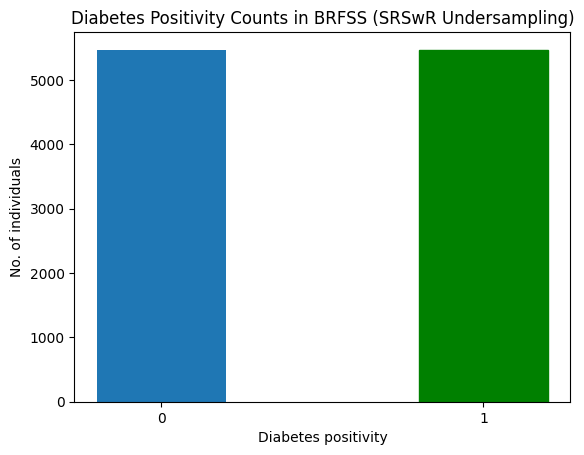

In [52]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [53]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [54]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6715 - loss: 0.6363 - val_AUC: 0.8896 - val_loss: 0.3870
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.3903 - val_AUC: 0.9057 - val_loss: 0.3268
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9108 - loss: 0.3348 - val_AUC: 0.9178 - val_loss: 0.3237
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3369 - val_AUC: 0.9208 - val_loss: 0.3085
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3298 - val_AUC: 0.9147 - val_loss: 0.3211
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9136 - loss: 0.3288 - val_AUC: 0.9222 - val_loss: 0.3153
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9190 - loss: 0.3177 - val_AUC: 0.9208 - val_loss: 0.3063
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3120 - val_AUC: 0.9216 - val_loss: 0.3022
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

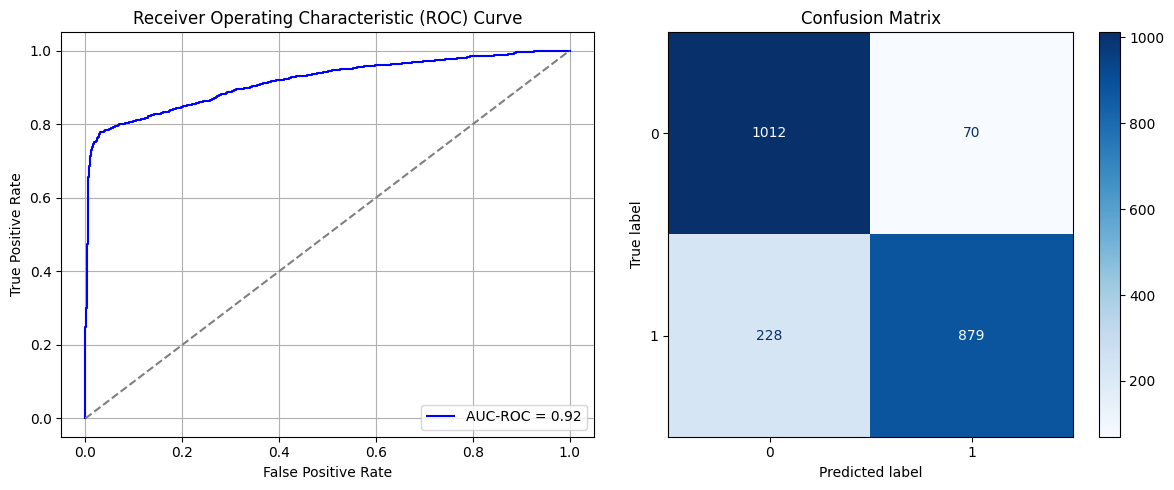

Best threshold based on F1-score: 0.7457936406135559
Time elapsed (performance): 14.208093638000037


<Sequential name=sequential_24, built=True>

In [55]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6779156203851978
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       707
           1       0.43      0.49      0.46       227

    accuracy                           0.72       934
   macro avg       0.63      0.64      0.64       934
weighted avg       0.73      0.72      0.73       934

FPR 0.2050919377652051 TPR: 0.4889867841409692 FNR: 0.5110132158590308 TNR: 0.7949080622347949


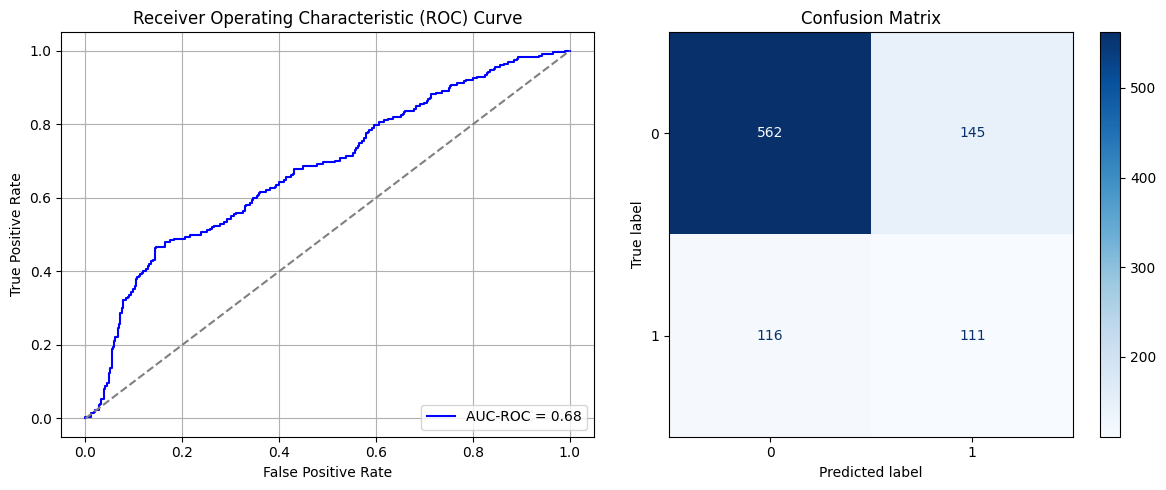

Best threshold based on F1-score: 0.9065902233123779
False Negative Rate: 0.5110132158590308
Time elapsed (performance): 0.4584189739999829


In [56]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

In [57]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6935 - loss: 0.7482 - val_AUC: 0.7167 - val_loss: 0.5020
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6995 - loss: 0.5213 - val_AUC: 0.7266 - val_loss: 0.4949
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7189 - loss: 0.5115 - val_AUC: 0.7289 - val_loss: 0.4949
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7044 - loss: 0.5230 - val_AUC: 0.7302 - val_loss: 0.4979
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7219 - loss: 0.5061 - val_AUC: 0.7294 - val_loss: 0.4936
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7282 - loss: 0.5183 - val_AUC: 0.7300 - val_loss: 0.4926
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7052 - loss: 0.5157 - val_AUC: 0.7297 - val_loss: 0.4924
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7256 - loss: 0.4825 - val_AUC: 0.7320 - val_loss: 0.4944
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7194 - loss: 0.5054 - va

(np.float64(0.10891089108910891), np.float64(0.6035242290748899))

In [58]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6765 - loss: 0.8937 - val_AUC: 0.0000e+00 - val_loss: 0.9358
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6999 - loss: 0.6601 - val_AUC: 0.0000e+00 - val_loss: 0.9056
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7098 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7455 - loss: 0.5646 - val_AUC: 0.0000e+00 - val_loss: 0.9178
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7065 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.9412
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7319 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.9184
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7098 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7028 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.11032531824611033), np.float64(0.5947136563876652))

In [59]:
times = 10

FPR = []
FNR = []

for i in range(times):
    # X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
    fpr, fnr = fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.7003 - loss: 0.8781 - val_AUC: 0.0000e+00 - val_loss: 0.9368
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6809 - loss: 0.7072 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7342 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7290 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7152 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8722
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7228 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.8470
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7010 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7134 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.6928 - loss: 0.9460 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7070 - loss: 0.6940 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6866 - loss: 0.6167 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7301 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8965
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7016 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8588
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7362 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.9186
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7190 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6915 - loss: 0.8725 - val_AUC: 0.0000e+00 - val_loss: 0.9310
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.9409
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7061 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7153 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9339
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.8239
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7079 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7251 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9444
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7177 - loss: 0.8064 - val_AUC: 0.0000e+00 - val_loss: 0.9282
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7021 - loss: 0.6399 - val_AUC: 0.0000e+00 - val_loss: 0.9187
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7055 - loss: 0.6056 - val_AUC: 0.0000e+00 - val_loss: 0.9674
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7220 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.9431
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7258 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7221 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7207 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9013
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7312 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7095 - loss: 0.8066 - val_AUC: 0.0000e+00 - val_loss: 0.9328
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7066 - loss: 0.6550 - val_AUC: 0.0000e+00 - val_loss: 0.9326
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7143 - loss: 0.5977 - val_AUC: 0.0000e+00 - val_loss: 0.9268
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7357 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7110 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9239
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7303 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8463
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7146 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.9332
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6919 - loss: 0.8506 - val_AUC: 0.0000e+00 - val_loss: 0.9548
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6845 - loss: 0.6743 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6921 - loss: 0.6107 - val_AUC: 0.0000e+00 - val_loss: 0.9056
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7025 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7465 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7512 - loss: 0.5585 - val_AUC: 0.0000e+00 - val_loss: 0.8886
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7129 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8405
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7012 - loss: 0.8463 - val_AUC: 0.0000e+00 - val_loss: 0.9601
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6900 - loss: 0.6532 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7305 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8939
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7245 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.9149
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7236 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.9275
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7068 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7379 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6940 - loss: 0.8290 - val_AUC: 0.0000e+00 - val_loss: 0.8897
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7038 - loss: 0.6717 - val_AUC: 0.0000e+00 - val_loss: 0.9448
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7040 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.9053
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7030 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7357 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7065 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8853
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7514 - loss: 0.5537 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7207 - loss: 0.7812 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7084 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7444 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7331 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7460 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6900 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7294 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9524
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7147 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7087 - loss: 0.8452 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6943 - loss: 0.6746 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6925 - loss: 0.6179 - val_AUC: 0.0000e+00 - val_loss: 0.9828
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7140 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7415 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.9268
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7205 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.9471
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [60]:
print(ParamFit)
ParamFit.to_csv('SRSwR_Fine_Tuning.csv')

        FPR       FNR
0  0.110325  0.594714
1  0.110325  0.594714
2  0.113154  0.594714
3  0.110325  0.594714
4  0.110325  0.594714
5  0.110325  0.594714
6  0.110325  0.594714
7  0.110325  0.594714
8  0.110325  0.594714
9  0.110325  0.594714


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [61]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train.iloc[:, -1])
print(y_T_train_Sy)


5472
16799
3.0699926900584797
3
[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 223, 226, 229, 232, 235, 238, 241, 244, 247, 250, 253, 256, 259, 262, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305, 308, 312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351, 355, 358, 361, 364, 367, 370, 373, 376, 379, 382, 385, 388, 391, 394, 398, 401, 404, 407, 410, 413, 416, 419, 422, 425, 428, 431, 434, 437, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468, 471, 474, 477, 480, 483, 487, 490, 493, 496, 499, 502, 505, 508, 511, 514, 517, 520, 523, 526, 530, 533, 536, 539, 542, 545, 548, 551, 554, 557, 560, 563, 566, 569, 573, 576, 579, 582, 585, 588, 591, 594, 597, 600, 603, 606, 609, 612, 61

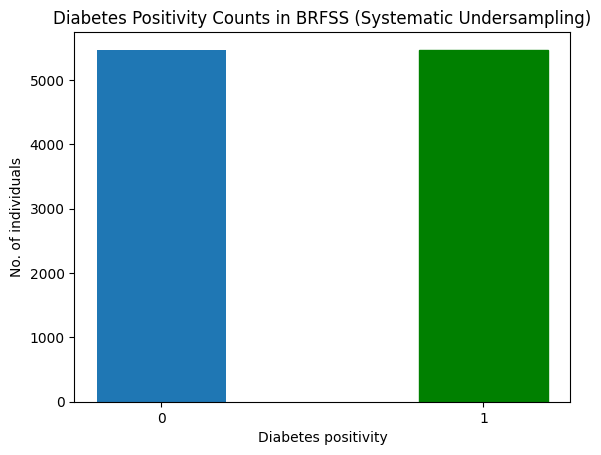

In [62]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [63]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [64]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7236 - loss: 0.6097 - val_AUC: 0.9059 - val_loss: 0.3392
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3510 - val_AUC: 0.9135 - val_loss: 0.3165
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3295 - val_AUC: 0.9185 - val_loss: 0.3076
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9202 - loss: 0.3198 - val_AUC: 0.9173 - val_loss: 0.3064
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3184 - val_AUC: 0.9173 - val_loss: 0.3212
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9160 - loss: 0.3217 - val_AUC: 0.9206 - val_loss: 0.3042
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3258 - val_AUC: 0.9198 - val_loss: 0.3057
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9230 - loss: 0.3111 - val_AUC: 0.9204 - val_loss: 0.3071
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

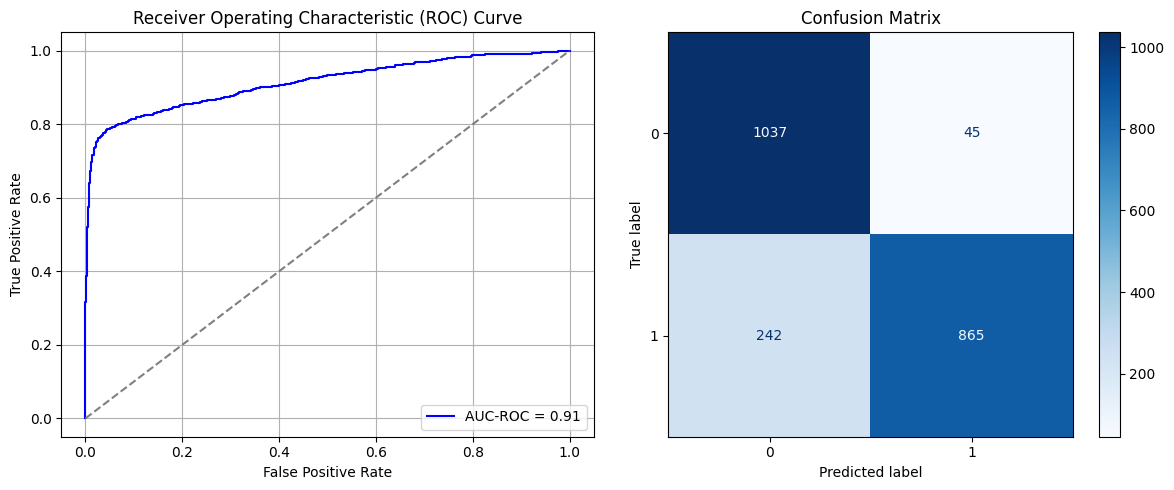

Best threshold based on F1-score: 0.49100756645202637
Time elapsed (performance): 13.994084195000141


<Sequential name=sequential_37, built=True>

In [65]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6922717444809301
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       707
           1       0.49      0.47      0.48       227

    accuracy                           0.75       934
   macro avg       0.66      0.66      0.66       934
weighted avg       0.75      0.75      0.75       934

FPR 0.15417256011315417 TPR: 0.46696035242290745 FNR: 0.5330396475770925 TNR: 0.8458274398868458


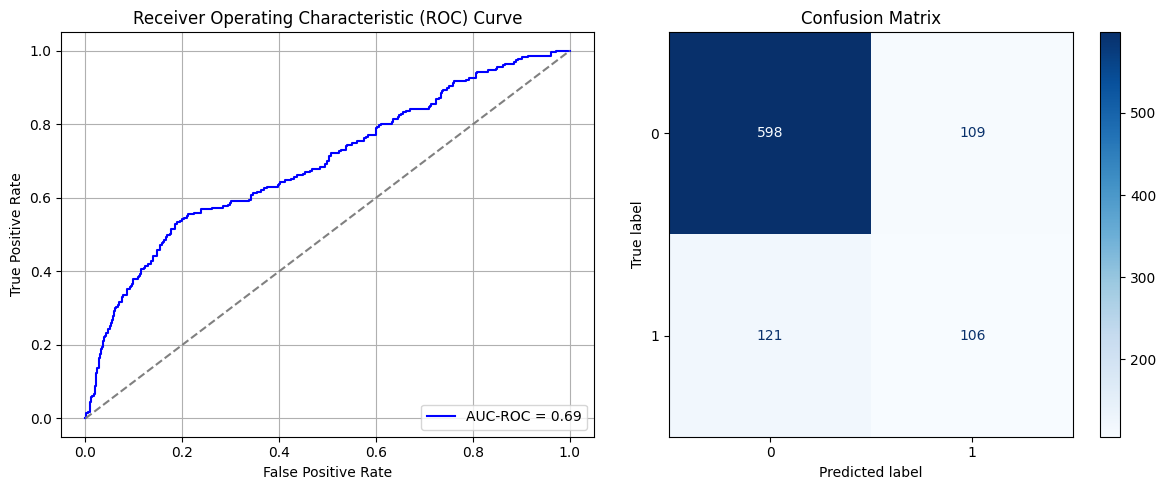

Best threshold based on F1-score: 0.9999621510505676
False Negative Rate: 0.5330396475770925
Time elapsed (performance): 0.5157250269999167


<ipython-input-24-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [66]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [67]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7234 - loss: 0.7189 - val_AUC: 0.7260 - val_loss: 0.4968
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6998 - loss: 0.5322 - val_AUC: 0.7286 - val_loss: 0.4934
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7126 - loss: 0.5037 - val_AUC: 0.7287 - val_loss: 0.4913
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7198 - loss: 0.5033 - val_AUC: 0.7283 - val_loss: 0.4973
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7197 - loss: 0.5060 - val_AUC: 0.7287 - val_loss: 0.4899
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7195 - loss: 0.5005 - val_AUC: 0.7295 - val_loss: 0.4902
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7202 - loss: 0.4969 - val_AUC: 0.7293 - val_loss: 0.4894
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7234 - loss: 0.5005 - val_AUC: 0.7298 - val_loss: 0.4900
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7016 - loss: 0.5117 - va

(np.float64(0.05091937765205092), np.float64(0.7092511013215859))

In [68]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7113 - loss: 0.8704 - val_AUC: 0.0000e+00 - val_loss: 1.0370
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7020 - loss: 0.6184 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7210 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9227
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7079 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8980
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6907 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.9145
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7090 - loss: 0.6111 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7438 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7072 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

(np.float64(0.11173974540311174), np.float64(0.5947136563876652))

In [69]:
times = 10

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - AUC: 0.7100 - loss: 0.8699 - val_AUC: 0.0000e+00 - val_loss: 1.0551
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.7097 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.9233
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7016 - loss: 0.6154 - val_AUC: 0.0000e+00 - val_loss: 0.8698
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7032 - loss: 0.6039 - val_AUC: 0.0000e+00 - val_loss: 0.9483
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7026 - loss: 0.6186 - val_AUC: 0.0000e+00 - val_loss: 0.8613
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7111 - loss: 0.6067 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6974 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7111 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6876 - loss: 0.9194 - val_AUC: 0.0000e+00 - val_loss: 1.0247
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6983 - loss: 0.6562 - val_AUC: 0.0000e+00 - val_loss: 0.9199
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7262 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7087 - loss: 0.6087 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7248 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7019 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.9371
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8518
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7393 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7202 - loss: 0.8436 - val_AUC: 0.0000e+00 - val_loss: 1.0500
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7115 - loss: 0.6322 - val_AUC: 0.0000e+00 - val_loss: 0.9295
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7010 - loss: 0.6127 - val_AUC: 0.0000e+00 - val_loss: 0.9284
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7034 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8527
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7128 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9173
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7188 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.9379
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6977 - loss: 0.6132 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6959 - loss: 0.8934 - val_AUC: 0.0000e+00 - val_loss: 1.0440
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6836 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.9345
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6960 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7057 - loss: 0.6091 - val_AUC: 0.0000e+00 - val_loss: 0.8892
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7140 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.9240
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7441 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7128 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7048 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_loss: 0.8877
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7167 - loss: 0.8090 - val_AUC: 0.0000e+00 - val_loss: 1.0751
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.6076 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7289 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7158 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8847
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7100 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8401
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.6878 - loss: 0.8881 - val_AUC: 0.0000e+00 - val_loss: 1.0347
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.6206 - val_AUC: 0.0000e+00 - val_loss: 0.9786
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7044 - loss: 0.6060 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7071 - loss: 0.6189 - val_AUC: 0.0000e+00 - val_loss: 0.9761
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7124 - loss: 0.6040 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7233 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.8952
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7215 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8777
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8263
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7133 - loss: 0.8452 - val_AUC: 0.0000e+00 - val_loss: 1.0348
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.6156 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9501
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7140 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8744
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7175 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6925 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.8965
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7279 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.9344
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6957 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.8651
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7403 - loss: 0.7585 - val_AUC: 0.0000e+00 - val_loss: 1.0866
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7101 - loss: 0.6117 - val_AUC: 0.0000e+00 - val_loss: 0.8815
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7238 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6998 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.9215
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7292 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7383 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.7019 - loss: 0.9095 - val_AUC: 0.0000e+00 - val_loss: 1.0370
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7161 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6959 - loss: 0.6133 - val_AUC: 0.0000e+00 - val_loss: 0.9263
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6904 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7275 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7030 - loss: 0.6057 - val_AUC: 0.0000e+00 - val_loss: 0.8880
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9489
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8529
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7074 - loss: 0.8549 - val_AUC: 0.0000e+00 - val_loss: 1.0696
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7033 - loss: 0.6290 - val_AUC: 0.0000e+00 - val_loss: 0.9600
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7102 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.9088
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6960 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7104 - loss: 0.6018 - val_AUC: 0.0000e+00 - val_loss: 0.9425
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7117 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7226 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.9228
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7326 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9381
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [70]:
print(ParamFit)
ParamFit.to_csv('Sy_Fine_Tuning.csv')

        FPR       FNR
0  0.110325  0.603524
1  0.111740  0.599119
2  0.117397  0.594714
3  0.110325  0.603524
4  0.111740  0.603524
5  0.113154  0.594714
6  0.110325  0.603524
7  0.114569  0.594714
8  0.106082  0.616740
9  0.114569  0.594714


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [71]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full.iloc[:,-1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train.iloc[:,-1], 10)
print(y_T_train_Sy)

5472
16799
3.0699926900584797
[13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 277, 280, 283, 286, 289, 292, 295, 298, 301, 304, 307, 310, 313, 316, 319, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 396, 399, 402, 405, 409, 412, 415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 452, 455, 458, 461, 464, 467, 470, 473, 476, 479, 482, 485, 488, 491, 494, 498, 501, 504, 507, 510, 513, 516, 519, 522, 525, 528, 531, 534, 537, 541, 544, 547, 550, 553, 556, 559, 562, 565, 568, 571, 574, 577, 580, 584, 587, 590, 593, 596, 599, 602, 605, 608, 611, 614, 617, 620, 623

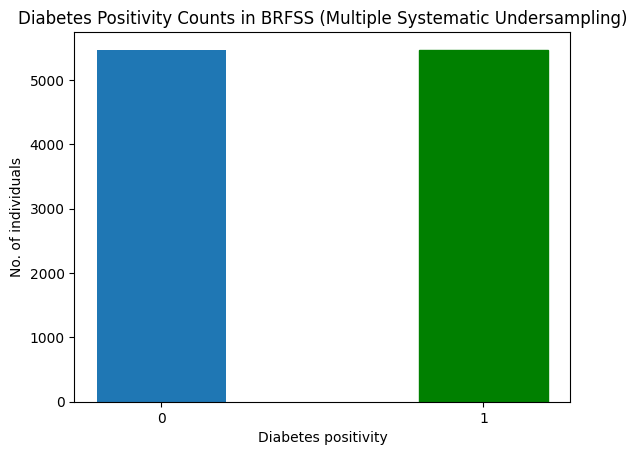

In [72]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [73]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8753, 22)
y_S_train: (8753,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [74]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7283 - loss: 0.6146 - val_AUC: 0.8976 - val_loss: 0.3771
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3599 - val_AUC: 0.8955 - val_loss: 0.3566
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9009 - loss: 0.3408 - val_AUC: 0.9149 - val_loss: 0.3338
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9187 - loss: 0.3166 - val_AUC: 0.9211 - val_loss: 0.3300
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9147 - loss: 0.3224 - val_AUC: 0.8860 - val_loss: 0.3861
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9094 - loss: 0.3322 - val_AUC: 0.9176 - val_loss: 0.3383
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9170 - loss: 0.3196 - val_AUC: 0.9221 - val_loss: 0.3301
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9200 - loss: 0.3119 - val_AUC: 0.9248 - val_loss: 0.3183
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

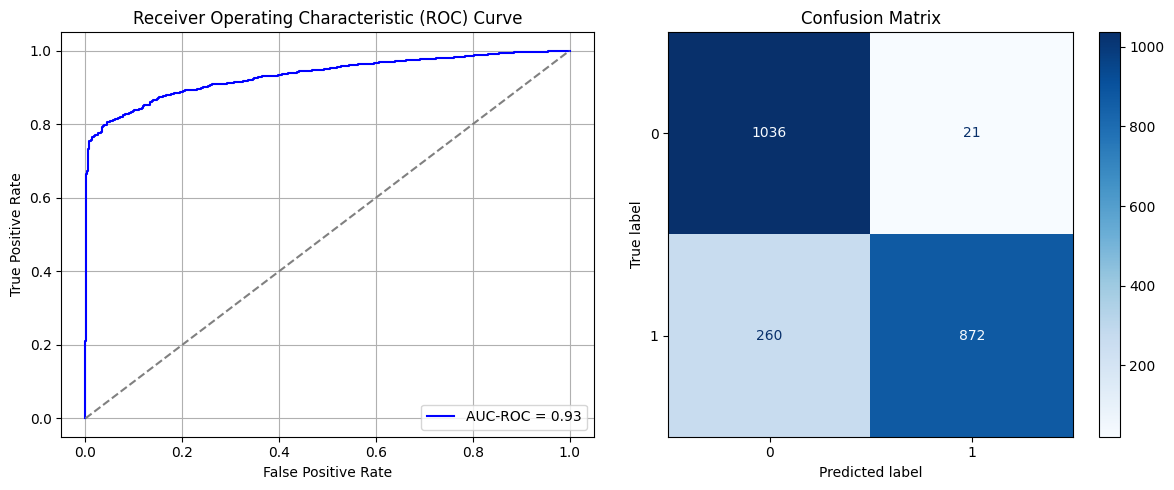

Best threshold based on F1-score: 0.2882900536060333
Time elapsed (performance): 15.059457946000066


<Sequential name=sequential_50, built=True>

In [75]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6964215616023528
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       707
           1       0.49      0.46      0.47       227

    accuracy                           0.75       934
   macro avg       0.66      0.65      0.66       934
weighted avg       0.75      0.75      0.75       934

FPR 0.15134370579915135 TPR: 0.4581497797356828 FNR: 0.5418502202643172 TNR: 0.8486562942008486


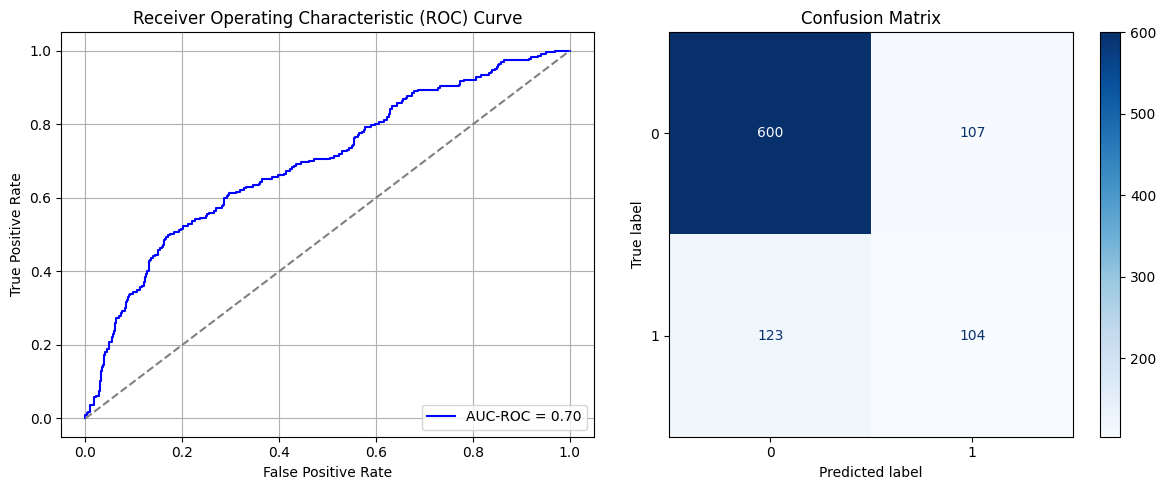

Best threshold based on F1-score: 0.32619985938072205
False Negative Rate: 0.5418502202643172
Time elapsed (performance): 0.5221551899999213


In [76]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [77]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7166 - loss: 0.6876 - val_AUC: 0.7222 - val_loss: 0.4954
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6914 - loss: 0.5235 - val_AUC: 0.7243 - val_loss: 0.4915
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7042 - loss: 0.5148 - val_AUC: 0.7360 - val_loss: 0.4908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7191 - loss: 0.5146 - val_AUC: 0.7358 - val_loss: 0.4911
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7117 - loss: 0.5121 - val_AUC: 0.7369 - val_loss: 0.4922
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7078 - loss: 0.5106 - val_AUC: 0.7352 - val_loss: 0.4892
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6984 - loss: 0.5053 - val_AUC: 0.7354 - val_loss: 0.4905
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7221 - loss: 0.5104 - val_AUC: 0.7336 - val_loss: 0.4925
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7199 - loss: 0.5065 - va

(np.float64(0.11032531824611033), np.float64(0.6035242290748899))

In [78]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.7093 - loss: 0.8407 - val_AUC: 0.0000e+00 - val_loss: 0.9373
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7123 - loss: 0.6333 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7031 - loss: 0.6087 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7081 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.9603
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7020 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.8883
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7204 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7131 - l

(np.float64(0.11598302687411598), np.float64(0.5903083700440529))

In [79]:
times = 10

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7289 - loss: 0.7809 - val_AUC: 0.0000e+00 - val_loss: 0.9840
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7052 - loss: 0.6217 - val_AUC: 0.0000e+00 - val_loss: 0.9384
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6789 - loss: 0.6249 - val_AUC: 0.0000e+00 - val_loss: 0.8959
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7234 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7133 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.9317
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6961 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7274 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7175 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7185 - loss: 0.7995 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6896 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.9311
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7077 - loss: 0.6258 - val_AUC: 0.0000e+00 - val_loss: 0.9721
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6951 - loss: 0.6190 - val_AUC: 0.0000e+00 - val_loss: 0.9332
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.6030 - val_AUC: 0.0000e+00 - val_loss: 0.9283
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6940 - loss: 0.6152 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6996 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7207 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.9591
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7038 - loss: 0.8592 - val_AUC: 0.0000e+00 - val_loss: 0.9298
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.6116 - val_AUC: 0.0000e+00 - val_loss: 0.9657
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6735 - loss: 0.6293 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6893 - loss: 0.6190 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6984 - loss: 0.6147 - val_AUC: 0.0000e+00 - val_loss: 0.8918
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6984 - loss: 0.6157 - val_AUC: 0.0000e+00 - val_loss: 0.9301
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7002 - loss: 0.6091 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6791 - loss: 0.6136 - val_AUC: 0.0000e+00 - val_loss: 0.9775
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6864 - loss: 0.8404 - val_AUC: 0.0000e+00 - val_loss: 0.9676
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7153 - loss: 0.6181 - val_AUC: 0.0000e+00 - val_loss: 0.9509
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7085 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.9281
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7198 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.9119
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8606
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7266 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8692
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7185 - loss: 0.6001 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_399 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6890 - loss: 0.9002 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7132 - loss: 0.6274 - val_AUC: 0.0000e+00 - val_loss: 0.9568
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7271 - loss: 0.6001 - val_AUC: 0.0000e+00 - val_loss: 0.9078
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7147 - loss: 0.6037 - val_AUC: 0.0000e+00 - val_loss: 0.9439
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7077 - loss: 0.6036 - val_AUC: 0.0000e+00 - val_loss: 0.9487
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7085 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7139 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7055 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_406 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6993 - loss: 0.8221 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7161 - loss: 0.6091 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7132 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.9576
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7210 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.9652
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7226 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7394 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7077 - loss: 0.6041 - val_AUC: 0.0000e+00 - val_loss: 0.9453
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7099 - loss: 0.6048 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_413 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7197 - loss: 0.8171 - val_AUC: 0.0000e+00 - val_loss: 0.9590
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7403 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6968 - loss: 0.6194 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6967 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.8599
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7281 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.9564
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6878 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.9073
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7102 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7044 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7058 - loss: 0.8474 - val_AUC: 0.0000e+00 - val_loss: 0.9509
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7137 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7145 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6900 - loss: 0.6151 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6933 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.9401
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7106 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8815
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7150 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.9121
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_427 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6911 - loss: 0.8656 - val_AUC: 0.0000e+00 - val_loss: 0.9891
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7109 - loss: 0.6314 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6890 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7194 - loss: 0.5985 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.8793
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7254 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6867 - loss: 0.6059 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_434 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7207 - loss: 0.8248 - val_AUC: 0.0000e+00 - val_loss: 0.9371
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7070 - loss: 0.6235 - val_AUC: 0.0000e+00 - val_loss: 0.9267
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7101 - loss: 0.6215 - val_AUC: 0.0000e+00 - val_loss: 0.9494
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7098 - loss: 0.6061 - val_AUC: 0.0000e+00 - val_loss: 0.9889
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7033 - loss: 0.6106 - val_AUC: 0.0000e+00 - val_loss: 0.9090
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7117 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7205 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9306
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [80]:
print(ParamFit)
ParamFit.to_csv('Sy_multi_Fine_Tuning.csv')

        FPR       FNR
0  0.117397  0.590308
1  0.118812  0.590308
2  0.118812  0.590308
3  0.115983  0.590308
4  0.118812  0.590308
5  0.117397  0.590308
6  0.115983  0.590308
7  0.111740  0.594714
8  0.115983  0.590308
9  0.114569  0.590308


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [81]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full.iloc[:, -1])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train.iloc[:, -1])
print(y_T_train_Sy)

5472
16799
1        0
2        0
3        0
4        0
5        0
        ..
905      1
10066    1
4043     1
203      1
1036     1
Name: Y2, Length: 33598, dtype: int64
958
2777
751     0
917     0
2627    0
3948    0
352     0
       ..
1871    1
1701    1
2897    1
2599    1
2607    1
Name: Y, Length: 1908, dtype: int64


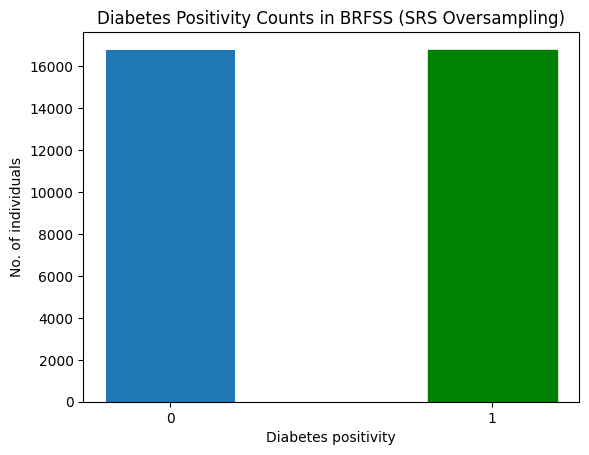

In [82]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [83]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_441 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7876 - loss: 0.5166 - val_AUC: 0.9153 - val_loss: 0.3294
Epoch 2/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9133 - loss: 0.3267 - val_AUC: 0.9255 - val_loss: 0.3191
Epoch 3/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9205 - loss: 0.3173 - val_AUC: 0.9248 - val_loss: 0.3110
Epoch 4/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9226 - loss: 0.3085 - val_AUC: 0.9276 - val_loss: 0.3093
Epoch 5/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9231 - loss: 0.3100 - val_AUC: 0.9280 - val_loss: 0.3047
Epoch 6/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9237 - loss: 0.3086 - val_AUC: 0.9257 - val_loss: 0.3093
Epoch 7/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9245 - loss: 0.3087 - val_AUC: 0.9295 - val_loss: 0.3030
Epoch 8/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9268 - loss: 0.3044 - val_AUC: 0.9310 - val_loss: 0.2981
Epoch 9/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AU

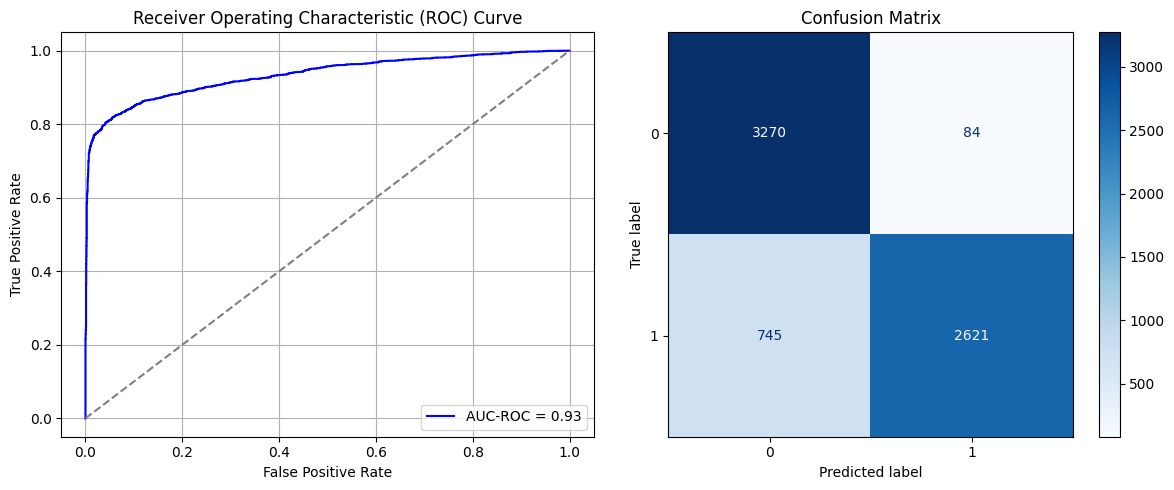

Best threshold based on F1-score: 0.36217087507247925
Time elapsed (performance): 29.922053972999947


<Sequential name=sequential_63, built=True>

In [84]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC-ROC: 0.6896111259961741
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       707
           1       0.50      0.45      0.47       227

    accuracy                           0.75       934
   macro avg       0.66      0.65      0.66       934
weighted avg       0.75      0.75      0.75       934

FPR 0.1485148514851485 TPR: 0.45374449339207046 FNR: 0.5462555066079295 TNR: 0.8514851485148515


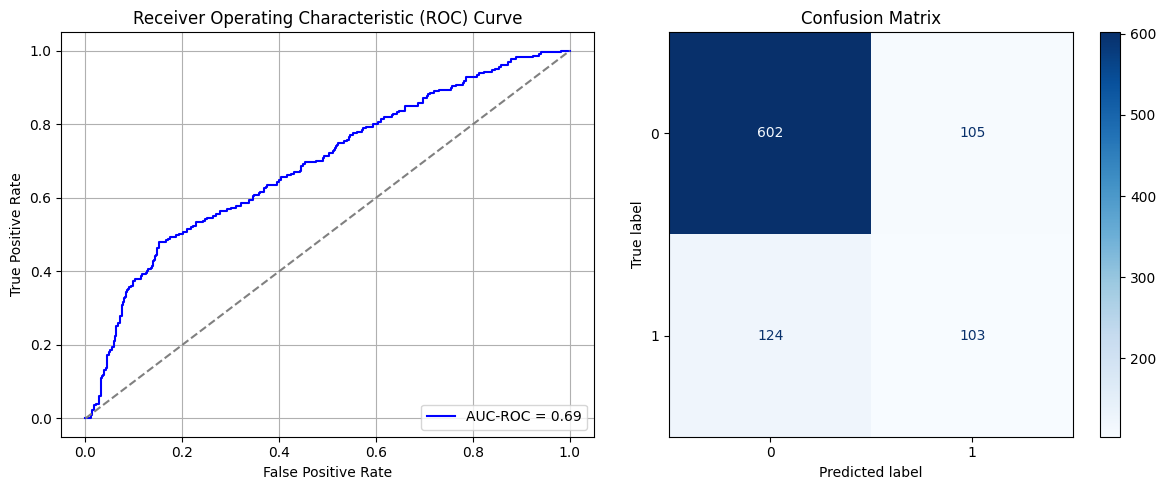

Best threshold based on F1-score: 0.9999412298202515
False Negative Rate: 0.5462555066079295
Time elapsed (performance): 0.5255338929998743


<ipython-input-24-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [85]:
Transductive_TL(model_source_SRS_ROS, X_T_test, y_T_test, "Target")

In [86]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_448 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7162 - loss: 0.7991 - val_AUC: 0.7168 - val_loss: 0.5015
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7227 - loss: 0.5176 - val_AUC: 0.7227 - val_loss: 0.4932
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7194 - loss: 0.5039 - val_AUC: 0.7245 - val_loss: 0.4919
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7270 - loss: 0.5037 - val_AUC: 0.7266 - val_loss: 0.4903
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7396 - loss: 0.4983 - val_AUC: 0.7278 - val_loss: 0.4888
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7291 - loss: 0.5134 - val_AUC: 0.7282 - val_loss: 0.4892
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7238 - loss: 0.5151 - val_AUC: 0.7282 - val_loss: 0.4888
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7363 - loss: 0.5104 - val_AUC: 0.7285 - val_loss: 0.4898
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7334 - loss: 0.4984 - va

(np.float64(0.09618104667609619), np.float64(0.6431718061674009))

In [87]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_455 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7068 - loss: 0.7632 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7081 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9199
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.9493
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7199 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9058
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7268 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9274
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7249 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7446 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_462 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6993 - loss: 0.7919 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7161 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7321 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.9386
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7228 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9305
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7290 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8995
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_469 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7153 - loss: 0.7644 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7199 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9640
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7267 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.9115
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.9531
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7368 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.9408
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7357 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8939
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7228 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7203 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9110
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_476 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7359 - loss: 0.7345 - val_AUC: 0.0000e+00 - val_loss: 0.9005
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7288 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8337
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7133 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7168 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7293 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9320
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7309 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9231
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7288 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7322 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_483 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7098 - loss: 0.7651 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7235 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7148 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8627
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7210 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7335 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.9452
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7307 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7200 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7179 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7176 - loss: 0.7468 - val_AUC: 0.0000e+00 - val_loss: 0.8980
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7263 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7250 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7295 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.9636
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7134 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9135
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7265 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8784
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7189 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7157 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 9/10
139/139 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_497 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6941 - loss: 0.8007 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8907
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7225 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7268 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7199 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8918
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7173 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8872
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7145 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9284
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7291 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7147 - loss: 0.7650 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7090 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.9702
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9248
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7144 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7280 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7306 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8584
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7435 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_511 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_515 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.7098 - loss: 0.7702 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7241 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7233 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7298 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.9210
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7167 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9291
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7284 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8752
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7222 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9735
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_518 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_520 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_524 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7121 - loss: 0.7451 - val_AUC: 0.0000e+00 - val_loss: 0.9346
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8620
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7210 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7165 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8901
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6969 - loss: 0.6011 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7144 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9020
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7267 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.9112
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7105 - loss: 0.7656 - val_AUC: 0.0000e+00 - val_loss: 0.8939
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7169 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8861
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7256 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7214 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8540
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9231
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7269 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7236 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7309 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7071 - loss: 0.7811 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7149 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9132
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7261 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7141 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8481
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7281 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9073
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7386 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.8801
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7083 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7346 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_539 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_540 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_545 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6991 - loss: 0.7695 - val_AUC: 0.0000e+00 - val_loss: 0.8828
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7355 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.9195
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7253 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9392
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9368
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7377 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7231 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7133 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7170 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_546 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7130 - loss: 0.7854 - val_AUC: 0.0000e+00 - val_loss: 0.8213
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7205 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.9316
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7246 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9126
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7050 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7164 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8619
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7204 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8851
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8470
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_553 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7195 - loss: 0.7492 - val_AUC: 0.0000e+00 - val_loss: 0.9437
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7251 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7303 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7149 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9020
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8973
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7387 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.9059
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7290 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.9080
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7261 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_565 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7053 - loss: 0.7365 - val_AUC: 0.0000e+00 - val_loss: 0.9101
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7102 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7084 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7218 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.9308
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7306 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9396
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7293 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7340 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7043 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_567 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7113 - loss: 0.7567 - val_AUC: 0.0000e+00 - val_loss: 0.9985
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7177 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7269 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8502
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8874
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7168 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9659
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7296 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7264 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7300 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8645
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_574 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_580 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7125 - loss: 0.7601 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7029 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9361
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7219 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7274 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7139 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.9288
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7227 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8922
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7311 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9161
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7209 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 9/10
139/139 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_581 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_585 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7120 - loss: 0.7591 - val_AUC: 0.0000e+00 - val_loss: 0.9216
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7043 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7148 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7364 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7221 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9262
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7139 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8457
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9054
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_588 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_590 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7299 - loss: 0.7277 - val_AUC: 0.0000e+00 - val_loss: 0.9375
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7094 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8867
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7325 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.8966
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7356 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8510
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9628
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7230 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8734
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7241 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9263
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7099 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_600 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_601 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7061 - loss: 0.7864 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7138 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7078 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9234
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7168 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8923
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7138 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7163 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7249 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.9142
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7164 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_602 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_603 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_604 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_605 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_606 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_608 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7111 - loss: 0.7739 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7217 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8992
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7324 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7300 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7048 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8850
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7312 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.9210
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7128 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7214 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8670
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_609 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_612 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_613 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7011 - loss: 0.7562 - val_AUC: 0.0000e+00 - val_loss: 0.8966
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7249 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8918
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7256 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9581
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7139 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.9439
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7090 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8444
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7360 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.9168
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7286 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8134
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7224 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.9331
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_616 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_619 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_620 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_621 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_622 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7172 - loss: 0.7487 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7235 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7228 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7273 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8810
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7352 - loss: 0.5665 - val_AUC: 0.0000e+00 - val_loss: 0.8290
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7151 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8772
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7097 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.9332
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_623 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_624 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_627 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_628 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_629 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7117 - loss: 0.7746 - val_AUC: 0.0000e+00 - val_loss: 0.9266
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7273 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9570
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7170 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8919
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7181 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7127 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7333 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8855
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7316 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9852
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7061 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9386
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_630 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_631 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_632 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_636 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7148 - loss: 0.7443 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7234 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9082
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7113 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7323 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7395 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8772
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7161 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.8965
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7254 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_637 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7060 - loss: 0.7778 - val_AUC: 0.0000e+00 - val_loss: 0.9210
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8586
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7170 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.9437
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7141 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7282 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7335 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8891
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7304 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9982
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7122 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.9323
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7094 - loss: 0.7660 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7189 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9195
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7327 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8580
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7172 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7393 - loss: 0.5696 - val_AUC: 0.0000e+00 - val_loss: 0.9266
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7269 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7234 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7303 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_651 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6981 - loss: 0.7735 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7162 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9096
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7225 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7131 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8340
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7236 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8877
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7248 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9205
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7257 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7234 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9555
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_658 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7203 - loss: 0.7488 - val_AUC: 0.0000e+00 - val_loss: 0.9252
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7240 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8795
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7336 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7227 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.9631
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7240 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.9238
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7277 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7295 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.9391
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7245 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_665 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_668 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6911 - loss: 0.7969 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7288 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8326
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7303 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7224 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8905
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7326 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7337 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7225 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7326 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_676 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7155 - loss: 0.7625 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7212 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7305 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7230 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8857
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7292 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7422 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7120 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_679 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_680 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7109 - loss: 0.7565 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7341 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7306 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8544
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9085
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7266 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9881
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7133 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8400
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7276 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_686 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_692 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7057 - loss: 0.7970 - val_AUC: 0.0000e+00 - val_loss: 0.9582
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7197 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8990
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7186 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7167 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.9373
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7226 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7384 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7237 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7312 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.8679
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_696 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7026 - loss: 0.7864 - val_AUC: 0.0000e+00 - val_loss: 0.9348
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7325 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.9096
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7251 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7281 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.9470
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7129 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9363
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7275 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8942
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7286 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.8839
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_704 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7007 - loss: 0.7811 - val_AUC: 0.0000e+00 - val_loss: 0.9605
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7285 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7269 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7276 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.9130
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7236 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9383
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7180 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7302 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_707 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_708 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_712 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7061 - loss: 0.7609 - val_AUC: 0.0000e+00 - val_loss: 0.9658
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7165 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7184 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9579
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9691
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7235 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7224 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7223 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8868
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7294 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9199
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_714 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_716 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7188 - loss: 0.7595 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7396 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9307
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7339 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7293 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.9421
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7297 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7136 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7311 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.9238
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7321 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_721 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6886 - loss: 0.8099 - val_AUC: 0.0000e+00 - val_loss: 0.9469
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7088 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.9330
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7286 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9345
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7095 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.9367
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7223 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.9480
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7320 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7340 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.9103
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_732 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7204 - loss: 0.7559 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7203 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8306
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7346 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7265 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7186 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.9183
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7212 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8847
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7332 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7110 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_735 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6916 - loss: 0.8215 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7229 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8886
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7042 - loss: 0.5982 - val_AUC: 0.0000e+00 - val_loss: 0.9620
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7391 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7221 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8344
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7289 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 9/10
139/139 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_742 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_744 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_748 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7247 - loss: 0.7459 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7277 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.8773
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7146 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9282
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8996
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7204 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8794
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7256 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7181 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8656
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7293 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.9256
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_752 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7088 - loss: 0.7448 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7171 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7165 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8847
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7335 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7254 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8423
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7231 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.9134
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7240 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.9175
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7077 - loss: 0.7342 - val_AUC: 0.0000e+00 - val_loss: 0.8935
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7331 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.9151
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7240 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7127 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7215 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9414
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7374 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9377
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7230 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.9020
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7125 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8750
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_763 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_764 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6970 - loss: 0.8000 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7216 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7191 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8273
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7358 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9425
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7351 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.9238
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7177 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9165
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7385 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_770 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_772 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_776 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7154 - loss: 0.7510 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7306 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9070
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7249 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7216 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9165
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8933
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7180 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7271 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_777 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7149 - loss: 0.7693 - val_AUC: 0.0000e+00 - val_loss: 0.9336
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6987 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7170 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8699
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7185 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8167
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7180 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8800
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7257 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7199 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7200 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8405
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_784 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_788 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7003 - loss: 0.7722 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7285 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7158 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.9263
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7234 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8974
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7094 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.8643
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7345 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7356 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9233
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_791 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_792 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_796 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6985 - loss: 0.7876 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7198 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.8958
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7348 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8379
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7167 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7338 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.8864
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7288 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7305 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.9015
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7252 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9464
Epoch 9/10
139/139 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_798 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_799 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_800 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_801 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_802 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_803 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_804 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6930 - loss: 0.7879 - val_AUC: 0.0000e+00 - val_loss: 0.8942
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7143 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7204 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8998
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7257 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7283 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7218 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7299 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7339 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━

In [88]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS_Fine_Tuning_Extension.csv')

         FPR       FNR
0   0.114569  0.599119
1   0.111740  0.603524
2   0.121641  0.590308
3   0.111740  0.599119
4   0.111740  0.599119
5   0.114569  0.599119
6   0.113154  0.599119
7   0.113154  0.599119
8   0.121641  0.590308
9   0.111740  0.599119
10  0.114569  0.599119
11  0.113154  0.599119
12  0.111740  0.599119
13  0.111740  0.603524
14  0.113154  0.599119
15  0.111740  0.599119
16  0.121641  0.594714
17  0.111740  0.603524
18  0.113154  0.599119
19  0.111740  0.603524
20  0.114569  0.599119
21  0.117397  0.599119
22  0.110325  0.607930
23  0.113154  0.599119
24  0.113154  0.599119
25  0.111740  0.599119
26  0.113154  0.599119
27  0.113154  0.599119
28  0.118812  0.599119
29  0.111740  0.599119
30  0.113154  0.599119
31  0.114569  0.599119
32  0.113154  0.599119
33  0.113154  0.599119
34  0.111740  0.603524
35  0.125884  0.581498
36  0.113154  0.599119
37  0.113154  0.599119
38  0.111740  0.599119
39  0.113154  0.599119
40  0.113154  0.599119
41  0.111740  0.599119
42  0.12164

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, we take $k=10$ for the source data sampling, and take $k=20$ for the target training data resampling.

In [89]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full.iloc[:, -1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train.iloc[:, -1], 20)
print(y_T_train_Sy)

5472
16799
Nsamples= 20.699926900584796
1        0
2        0
3        0
4        0
5        0
        ..
22067    1
22098    1
22128    1
22160    1
22221    1
Name: Y2, Length: 33211, dtype: int64
958
2777
Nsamples= 37.97494780793319
751     0
4442    0
917     0
1091    0
4324    0
       ..
387     1
3204    1
4641    1
1429    1
591     1
Name: Y, Length: 5474, dtype: int64


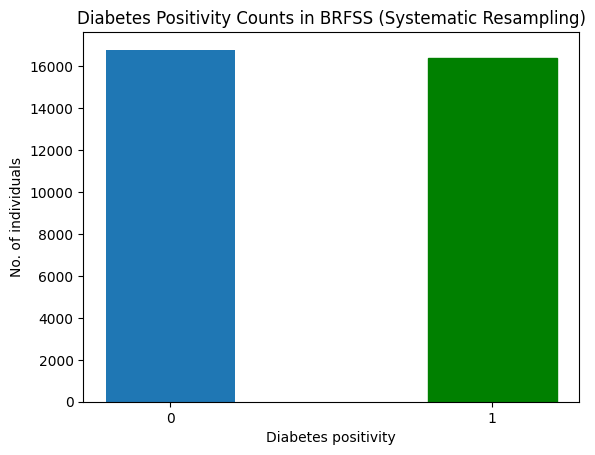

In [90]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [91]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_805 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8232 - loss: 0.4887 - val_AUC: 0.9152 - val_loss: 0.3275
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9181 - loss: 0.3197 - val_AUC: 0.9146 - val_loss: 0.3312
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9179 - loss: 0.3160 - val_AUC: 0.9199 - val_loss: 0.3163
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9221 - loss: 0.3133 - val_AUC: 0.9261 - val_loss: 0.3187
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9210 - loss: 0.3146 - val_AUC: 0.9237 - val_loss: 0.3309
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9227 - loss: 0.3093 - val_AUC: 0.9282 - val_loss: 0.3006
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9274 - loss: 0.2998 - val_AUC: 0.9260 - val_loss: 0.3025
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9279 - loss: 0.2975 - val_AUC: 0.9238 - val_loss: 0.3146
Epoch 9/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AU

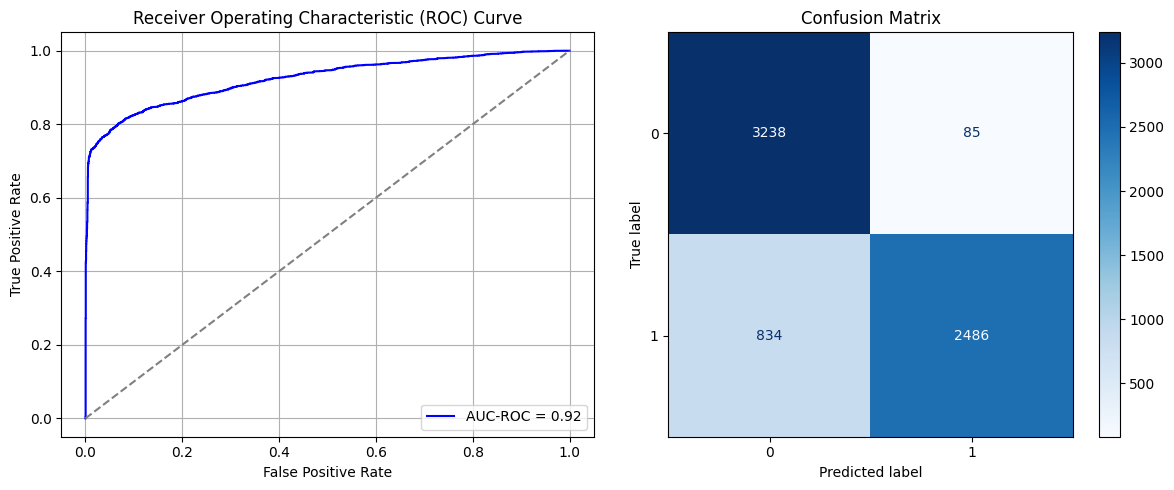

Best threshold based on F1-score: 0.30432695150375366
Time elapsed (performance): 25.951515427999993


<Sequential name=sequential_115, built=True>

In [92]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC-ROC: 0.6767753553203024
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       707
           1       0.49      0.48      0.48       227

    accuracy                           0.75       934
   macro avg       0.66      0.66      0.66       934
weighted avg       0.75      0.75      0.75       934

FPR 0.15841584158415842 TPR: 0.4757709251101322 FNR: 0.5242290748898678 TNR: 0.8415841584158416


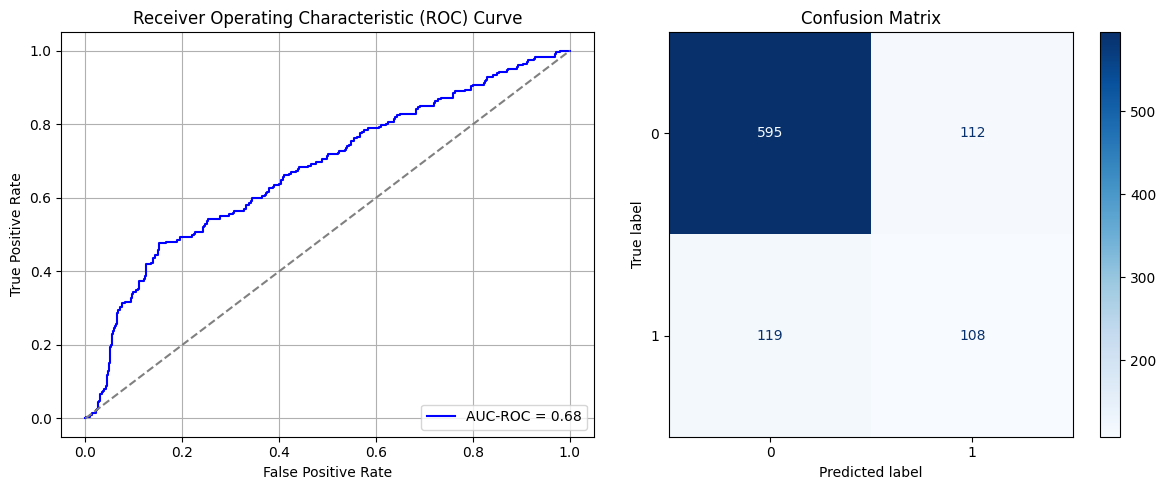

Best threshold based on F1-score: 0.999996542930603
False Negative Rate: 0.5242290748898678
Time elapsed (performance): 0.4607404419998602


<ipython-input-24-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [93]:
Transductive_TL(model_source_Sy_ROS, X_T_test, y_T_test, "Target")

In [94]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_812 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_815 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_816 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_817 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_818 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.7012 - loss: 0.8148 - val_AUC: 0.7008 - val_loss: 0.5226
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6882 - loss: 0.5273 - val_AUC: 0.7157 - val_loss: 0.4981
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7129 - loss: 0.5127 - val_AUC: 0.7121 - val_loss: 0.5044
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7250 - loss: 0.5162 - val_AUC: 0.7174 - val_loss: 0.4976
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7032 - loss: 0.5166 - val_AUC: 0.7203 - val_loss: 0.4970
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7169 - loss: 0.4912 - val_AUC: 0.7215 - val_loss: 0.4945
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7086 - loss: 0.4925 - val_AUC: 0.7251 - val_loss: 0.4954
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7225 - loss: 0.5006 - val_AUC: 0.7239 - val_loss: 0.4944
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6999 - loss: 0.5203 - v

(np.float64(0.09476661951909476), np.float64(0.6343612334801763))

In [96]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_826 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_828 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_832 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7004 - loss: 0.7791 - val_AUC: 0.0000e+00 - val_loss: 0.8534
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6967 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9460
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7168 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7033 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8859
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7096 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7213 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

(np.float64(0.11456859971711457), np.float64(0.5991189427312775))

In [97]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_833 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_836 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6875 - loss: 0.8573 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7122 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.9295
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7091 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8432
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7048 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8529
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7247 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8854
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7011 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.8539
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7078 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8254
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7274 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.8522
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_840 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6933 - loss: 0.8001 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7112 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7061 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7092 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7213 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9073
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.9240
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7370 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.8351
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7194 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.8465
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_847 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_852 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7043 - loss: 0.7875 - val_AUC: 0.0000e+00 - val_loss: 0.8626
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7155 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7188 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7179 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8431
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7068 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7080 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7181 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9061
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_854 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_860 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6930 - loss: 0.8136 - val_AUC: 0.0000e+00 - val_loss: 0.8797
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7208 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8961
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6969 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8291
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7226 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8560
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7087 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.9215
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7224 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7307 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7161 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_861 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_864 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_865 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_866 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_867 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6819 - loss: 0.8261 - val_AUC: 0.0000e+00 - val_loss: 0.8608
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7067 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8402
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7018 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7271 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7060 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7131 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7106 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8888
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7295 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8846
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_868 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_869 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_870 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_872 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_873 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_874 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6892 - loss: 0.8128 - val_AUC: 0.0000e+00 - val_loss: 0.8567
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7107 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8818
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7117 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7284 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.9142
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7294 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8500
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7206 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8642
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7227 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7157 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8408
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_875 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_876 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_877 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_878 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_879 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_880 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_881 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7023 - loss: 0.7784 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6928 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9220
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7018 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8242
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6956 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7191 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7245 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8986
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7216 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_882 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_883 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_884 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_885 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_886 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_887 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_888 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6881 - loss: 0.8344 - val_AUC: 0.0000e+00 - val_loss: 0.8658
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7028 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.8901
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7233 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.8484
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7100 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8633
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7166 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8857
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7294 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.8867
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7264 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_889 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_890 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_891 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_892 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_893 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_894 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_895 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6874 - loss: 0.8281 - val_AUC: 0.0000e+00 - val_loss: 0.8963
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7019 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7168 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.9420
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7124 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8645
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7002 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8621
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9153
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7230 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_896 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_897 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_898 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_899 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_900 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_901 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_902 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.6859 - loss: 0.8332 - val_AUC: 0.0000e+00 - val_loss: 0.8570
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6906 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8680
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7060 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7053 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7177 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.8426
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7147 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.9070
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7235 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8657
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7045 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_903 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6812 - loss: 0.8573 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7114 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9182
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7076 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8968
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7163 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8961
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7173 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8577
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7155 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7121 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9131
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_910 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6950 - loss: 0.8070 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7101 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7106 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9246
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7092 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7194 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7150 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7061 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7043 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9277
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_917 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_918 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_919 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_920 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_921 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_922 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_923 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6978 - loss: 0.8116 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6952 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.9504
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7019 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8998
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7076 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8219
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7213 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 9/10
137/137 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_924 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_925 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_926 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_927 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_928 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_929 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_930 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6845 - loss: 0.8266 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7009 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7020 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.9105
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7211 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7098 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8391
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7156 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_931 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_935 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6916 - loss: 0.8142 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7090 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9088
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6958 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7125 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7204 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7322 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.8412
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7236 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7111 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8640
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_938 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_939 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_943 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7014 - loss: 0.8148 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7000 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.9553
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6950 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7109 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7062 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8640
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.9181
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7255 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8255
Epoch 9/10
137/137 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_945 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_947 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_951 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6845 - loss: 0.8262 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7009 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6994 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7084 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7041 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8823
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7288 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.8429
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7121 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8507
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_952 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_955 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6836 - loss: 0.8497 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7030 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7097 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8874
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7201 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7093 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8502
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7146 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9034
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7086 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7280 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_959 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_963 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6889 - loss: 0.8239 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7111 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6861 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7180 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8409
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7162 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7052 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.9088
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7100 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8389
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_966 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_971 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6942 - loss: 0.8068 - val_AUC: 0.0000e+00 - val_loss: 0.8724
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7290 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9211
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9023
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7087 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8636
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7190 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8406
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7236 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8888
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7149 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7219 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_973 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6870 - loss: 0.8236 - val_AUC: 0.0000e+00 - val_loss: 0.8343
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7233 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.9304
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7105 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.9152
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8853
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6946 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7127 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6996 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8848
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7095 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_980 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6867 - loss: 0.8147 - val_AUC: 0.0000e+00 - val_loss: 0.9355
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6905 - loss: 0.6111 - val_AUC: 0.0000e+00 - val_loss: 0.8662
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7015 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_loss: 0.9413
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7000 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8468
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7267 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7064 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6886 - loss: 0.8406 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6953 - loss: 0.6021 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7132 - loss: 0.5677 - val_AUC: 0.0000e+00 - val_loss: 0.8336
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7165 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8425
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7154 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7135 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8255
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7172 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8780
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7206 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8116
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_994 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6957 - loss: 0.8316 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7092 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7140 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7139 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7223 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8627
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7006 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9328
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7085 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7199 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1001 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1007 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6963 - loss: 0.8352 - val_AUC: 0.0000e+00 - val_loss: 0.9332
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7096 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.9158
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7075 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7186 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8888
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7116 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6957 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.8872
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7011 - loss: 0.5966 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7270 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8398
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1008 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6838 - loss: 0.8502 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6925 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7143 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8502
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.9309
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7089 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7114 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7110 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8479
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1015 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1021 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6882 - loss: 0.8469 - val_AUC: 0.0000e+00 - val_loss: 0.8056
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7023 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.8134
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7142 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7150 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.9281
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7108 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9212
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7240 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7150 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8608
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7255 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1022 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1023 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7006 - loss: 0.8076 - val_AUC: 0.0000e+00 - val_loss: 0.9019
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7153 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8864
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7140 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7128 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7076 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8724
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7211 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8706
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7168 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7158 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8971
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1035 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6944 - loss: 0.7944 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7017 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7103 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7126 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7245 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7181 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8521
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7069 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1036 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1037 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1038 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7060 - loss: 0.7931 - val_AUC: 0.0000e+00 - val_loss: 0.8185
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7052 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7020 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7148 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7167 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8295
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7180 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9078
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7090 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7279 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.8675
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1043 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1044 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1045 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1049 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6880 - loss: 0.7790 - val_AUC: 0.0000e+00 - val_loss: 0.8242
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6932 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.9438
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7222 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7150 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7188 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8322
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7144 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8654
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7082 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1051 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1052 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1056 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6933 - loss: 0.8283 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7162 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7095 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8400
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7106 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.9618
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7184 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7078 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8932
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7155 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1059 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1063 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6932 - loss: 0.8187 - val_AUC: 0.0000e+00 - val_loss: 0.9223
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6924 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7143 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8055
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7132 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9145
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7175 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9085
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7272 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7130 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8164
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1064 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1065 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6932 - loss: 0.8210 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8973
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7228 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7126 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7262 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7181 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8469
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7158 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7082 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1073 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1077 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6929 - loss: 0.8441 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7042 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6978 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7220 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7026 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8656
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7182 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8273
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7155 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7034 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8642
Epoch 9/10
137/137 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1078 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1079 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.7015 - loss: 0.7902 - val_AUC: 0.0000e+00 - val_loss: 0.8662
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6855 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 0.9012
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7130 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8686
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7089 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7035 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8700
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7119 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7193 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7102 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1087 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6941 - loss: 0.8119 - val_AUC: 0.0000e+00 - val_loss: 0.9139
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7055 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8670
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7124 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8905
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7183 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7113 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7266 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.9277
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7164 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7178 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9189
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7025 - loss: 0.7760 - val_AUC: 0.0000e+00 - val_loss: 0.9157
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7097 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7084 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7150 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7179 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7041 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8676
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7103 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7181 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8376
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1099 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1101 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6931 - loss: 0.7894 - val_AUC: 0.0000e+00 - val_loss: 0.8186
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7041 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7046 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8782
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7076 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8253
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7093 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.9139
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7104 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7059 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 9/10
137/137 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1106 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1107 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6931 - loss: 0.8071 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6906 - loss: 0.6061 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7119 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7167 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.9235
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7138 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7288 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7035 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8823
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7174 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1116 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1119 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6929 - loss: 0.8420 - val_AUC: 0.0000e+00 - val_loss: 0.8950
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7062 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7082 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6968 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7089 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7080 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8569
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7164 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7171 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1120 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1122 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6879 - loss: 0.8524 - val_AUC: 0.0000e+00 - val_loss: 0.8203
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7151 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.9000
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7216 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8563
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7116 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8117
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7112 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7112 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.9410
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7063 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7255 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 9/10
137/137 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1129 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1133 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7106 - loss: 0.7721 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7072 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8272
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7235 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7175 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8410
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7183 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7157 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1135 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6877 - loss: 0.8378 - val_AUC: 0.0000e+00 - val_loss: 0.9301
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7198 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9157
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7063 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7068 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7145 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8612
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7289 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8581
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7204 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1147 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6729 - loss: 0.8456 - val_AUC: 0.0000e+00 - val_loss: 0.8552
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7070 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6817 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 0.8251
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7042 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8841
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7294 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.9085
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7201 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8408
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7373 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.8861
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7206 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1148 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1149 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6865 - loss: 0.8442 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6985 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7127 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7246 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7128 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7119 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8578
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7029 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7215 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1157 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1161 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6695 - loss: 0.8640 - val_AUC: 0.0000e+00 - val_loss: 0.9703
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6939 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.8968
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7023 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.8076
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7174 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8577
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7281 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.9272
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7271 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7155 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8409
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1162 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1163 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1164 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1168 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6865 - loss: 0.8236 - val_AUC: 0.0000e+00 - val_loss: 0.8567
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7033 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7166 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9196
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7117 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9343
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7106 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1169 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1170 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1171 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1175 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6914 - loss: 0.8092 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7149 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8790
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7094 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8567
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7089 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.9329
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7223 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.8405
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7226 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.9130
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7169 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8465
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1176 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1177 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1178 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1182 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6986 - loss: 0.8254 - val_AUC: 0.0000e+00 - val_loss: 0.9061
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7157 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8640
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7102 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7184 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7210 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8686
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7278 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.8720
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7246 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7252 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.8499
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━

In [99]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS_Fine_Tuning_Extension.csv')

         FPR       FNR
0   0.111740  0.603524
1   0.114569  0.599119
2   0.117397  0.590308
3   0.115983  0.599119
4   0.115983  0.594714
5   0.118812  0.590308
6   0.115983  0.590308
7   0.118812  0.590308
8   0.114569  0.599119
9   0.115983  0.599119
10  0.115983  0.594714
11  0.115983  0.599119
12  0.118812  0.590308
13  0.108911  0.603524
14  0.115983  0.594714
15  0.111740  0.603524
16  0.115983  0.590308
17  0.115983  0.599119
18  0.115983  0.599119
19  0.115983  0.594714
20  0.117397  0.590308
21  0.115983  0.594714
22  0.115983  0.594714
23  0.115983  0.594714
24  0.117397  0.590308
25  0.115983  0.594714
26  0.115983  0.594714
27  0.115983  0.599119
28  0.115983  0.594714
29  0.113154  0.599119
30  0.115983  0.594714
31  0.115983  0.599119
32  0.108911  0.603524
33  0.118812  0.594714
34  0.115983  0.594714
35  0.115983  0.590308
36  0.115983  0.594714
37  0.118812  0.590308
38  0.115983  0.594714
39  0.120226  0.590308
40  0.115983  0.594714
41  0.115983  0.594714
42  0.11598